## Introduction
This notebook tries to take in a sample dataset in notebook environment and run some tests to demo the verification of differential privacy algorithms. 

### Load the DP Verification Modules

In [1]:
import pandas as pd
import dp_verification as dp
import aggregation as agg
import warnings
warnings.filterwarnings('ignore')

### Load Data

In [2]:
dv = dp.DPVerification(dataset_size=10000)
ag = agg.Aggregation(t=1, repeat_count=10000)

Loaded 10000 records


### Test Parameters

In [3]:
# Using the auto method of np.histogram to decide bin size
# Maximum of the ‘sturges’ and ‘fd’ estimators. Provides good all around performance.
numbins = 0

## Exact Counts

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.0  Stdev fD1:  0.0  Mean fD2:  9999.0  Stdev fD2:  0.0

KS 2-sample Test Result:  Ks_2sampResult(statistic=1.0, pvalue=0.0) 

Wasserstein Distance:  0.0 

DP Predicate Test: False 



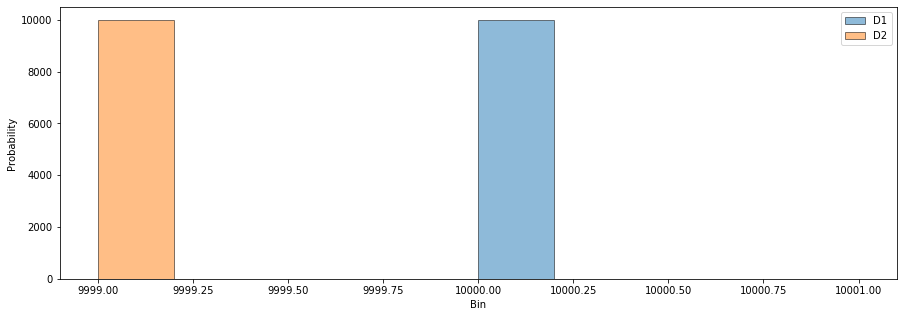

In [4]:
dp_exact, ks_exact, ws_exact = dv.aggtest(ag.exact_count, 'UserId', binsize = "unity", bound = False, exact = True)

If we do exact count repeatedly on a set D1 of 10K records and set D1 of 9,999 records (neighboring datasets), we shall get two histograms that are easily distinguishable from each other. So we can make out the extra record is in D1 vs D2. This is a trivial case of re-identification as it leads us to infer net new information about an individual record being part of D1 vs D2. 

#### Exact count fails the DP test

## Buggy Implementation of DP

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10005.00640527369  Stdev fD1:  2.872289302860187  Mean fD2:  10003.992950500719  Stdev fD2:  2.887608362720967

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1074, pvalue=1.2941082951613566e-50) 

Wasserstein Distance:  2.9655172413793096 

DP Predicate Test: False 



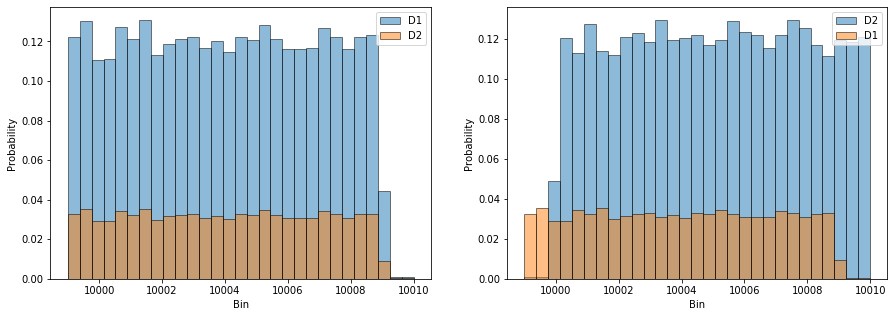

In [5]:
dp_buggy, ks_buggy, ws_buggy = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False,bound = True)

#### We can see that the histograms are not bounded. The test is able to uncover this implementation of DP noisy count is incorrect which is what we'd expect this test to uncover. 

## [DP Implementation as per MSR equations](https://www.yammer.com/microsoft.com/#/files/182490914816)

### COUNT Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.95480932162  Stdev fD1:  5.301563575745068  Mean fD2:  9998.998384731454  Stdev fD2:  5.3200400066447

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0784, pvalue=3.808765148627586e-27) 

Wasserstein Distance:  5.45679012345679 

DP Predicate Test: True 



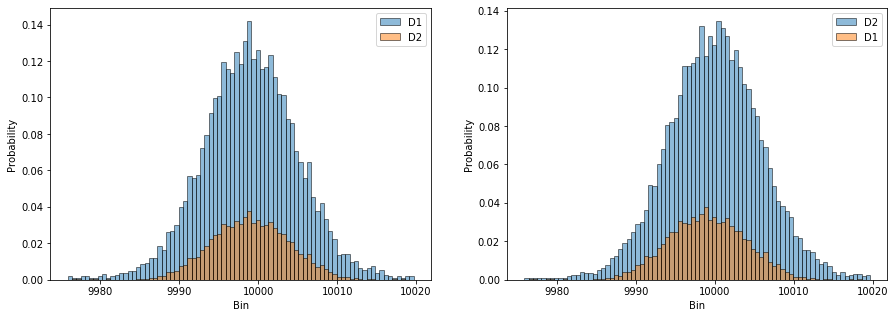

In [6]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False)

#### Noisy COUNT aggregation passes the DP Predicate test

### SUM Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.054263432346  Stdev fD1:  64.51719634087591  Mean fD2:  20009.962483381896  Stdev fD2:  63.84899576819309

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0275, pvalue=0.0010385517933069264) 

Wasserstein Distance:  4.070588235294117 

DP Predicate Test: True 



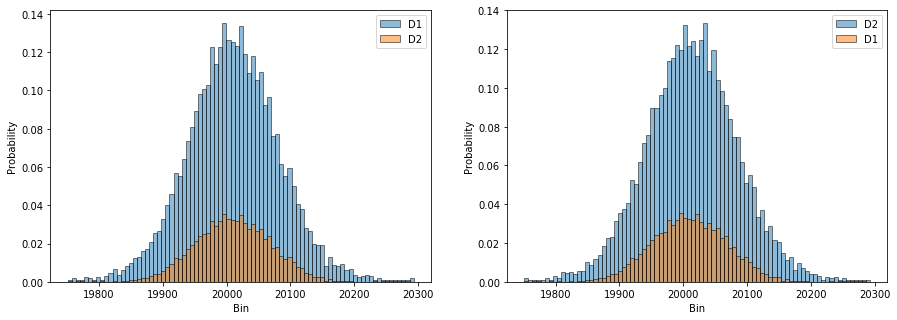

In [7]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto")

#### Noisy SUM aggregation passes the DP predicate test

### Mean Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.001271207718558  Stdev fD1:  0.0064890539614701785  Mean fD2:  2.001484926140308  Stdev fD2:  0.006470230589010468

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0165, pvalue=0.13138496726749369) 

Wasserstein Distance:  5.037974683544304 

DP Predicate Test: True 



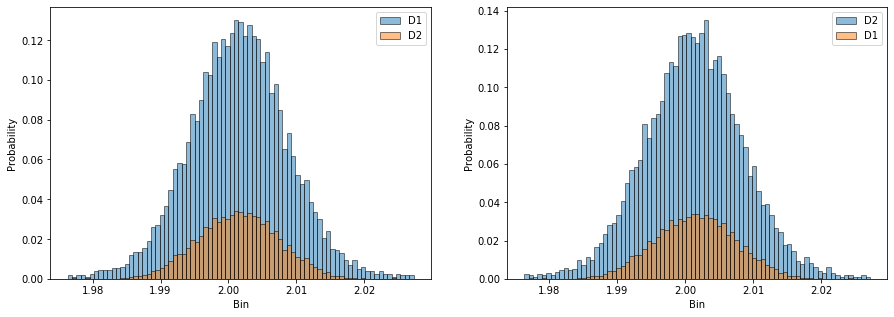

In [8]:
dp_mean, ks_mean, ws_mean = dv.aggtest(ag.dp_mean, 'Usage', binsize="auto", debug=False, plot=True)

#### Noisy mean passes the DP Predicate test

### Variance Test

Length of D1:  10000  Length of D2:  9999
Mean fD1:  2.0518948383786015  Stdev fD1:  0.09250734414565505  Mean fD2:  2.051949471009194  Stdev fD2:  0.09405594151391301

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0137, pvalue=0.30504141099080584) 

Wasserstein Distance:  6.5352112676056375 

DP Predicate Test: True 



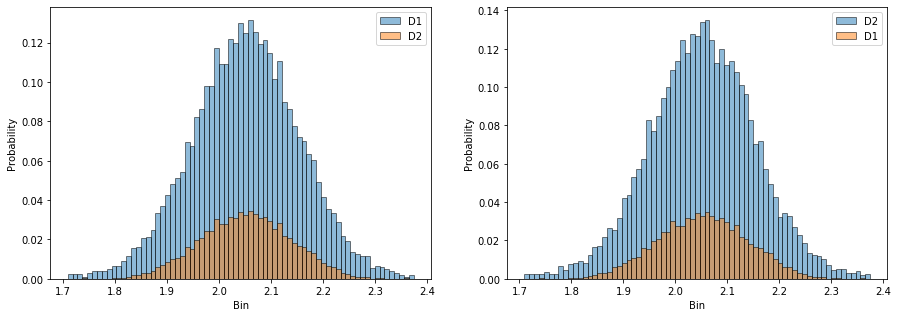

In [9]:
dp_var, ks_var, ws_var = dv.aggtest(ag.dp_var, 'Usage', binsize="auto", debug=False)

#### Noisy variance passes the DP Predicate test

### Comparing fD1 and fD2 without bounding

Length of D1:  10000  Length of D2:  9999
Mean fD1:  9999.980325412766  Stdev fD1:  5.371379137621207  Mean fD2:  9999.031378543827  Stdev fD2:  5.288191355084051

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28) 

Wasserstein Distance:  4.951219512195123 

DP Predicate Test: True 



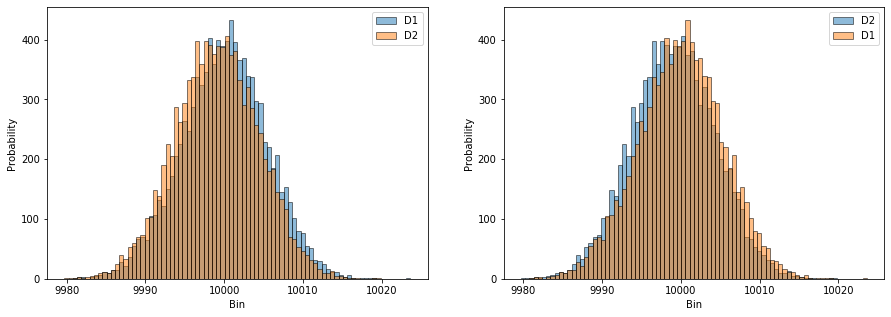

(True,
 Ks_2sampResult(statistic=0.0794, pvalue=7.835640605114273e-28),
 4.951219512195123)

In [10]:
dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug = False, bound=False)

### Plotting KS Test Results by different aggregate functions

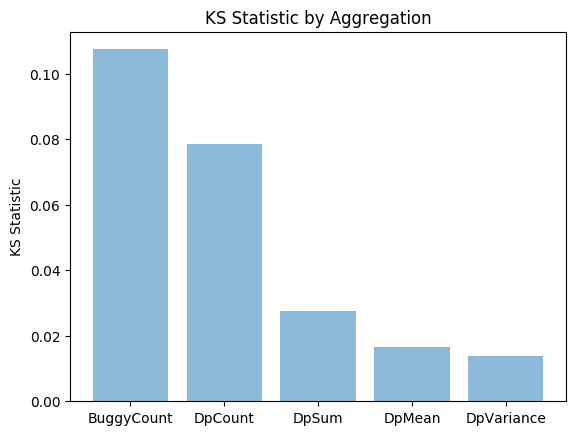

In [11]:
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt

objects = ('BuggyCount', 'DpCount', 'DpSum', 'DpMean', 'DpVariance')
y_pos = np.arange(len(objects))

ks_stat = [ks_buggy[0],
          ks_count[0],
          ks_sum[0],
          ks_mean[0],
          ks_var[0]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS Statistic')
plt.title('KS Statistic by Aggregation')

plt.show()

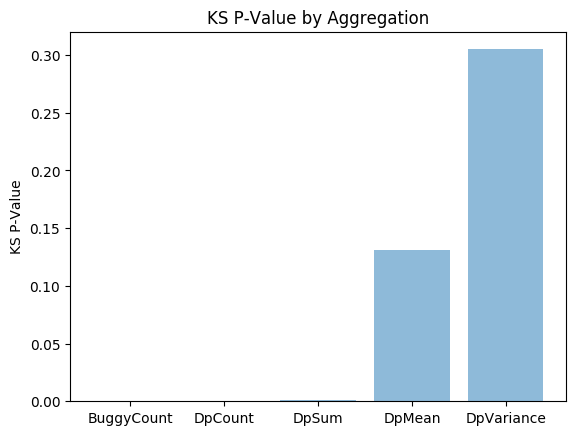

In [12]:
ks_stat = [ks_buggy[1],
          ks_count[1],
          ks_sum[1],
          ks_mean[1],
          ks_var[1]]

plt.bar(y_pos, ks_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('KS P-Value')
plt.title('KS P-Value by Aggregation')

plt.show()

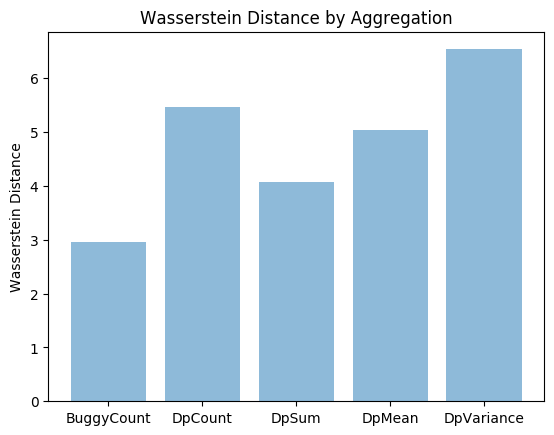

In [13]:
ws_stat = [ws_buggy,
          ws_count,
          ws_sum,
          ws_mean,
          ws_var]

plt.bar(y_pos, ws_stat, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Wasserstein Distance')
plt.title('Wasserstein Distance by Aggregation')

plt.show()

### Time to run the DP Tests

In [14]:
import time
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.003150446026  Stdev fD1:  5.329548568121991  Mean fD2:  9999.068096604222  Stdev fD2:  5.345181279124184

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0682, pvalue=1.21976233733592e-20) 

Wasserstein Distance:  4.409638554216866 

DP Predicate Test: True 

--- 0.05126166343688965 seconds ---


In [15]:
start_time = time.time()
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_sum, 'Usage', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20012.521400350048  Stdev fD1:  64.33678728785993  Mean fD2:  20009.570909004782  Stdev fD2:  63.991294298451635

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0212, pvalue=0.022340230544746754) 

Wasserstein Distance:  5.788235294117644 

DP Predicate Test: True 

--- 0.061855316162109375 seconds ---


In [16]:
start_time = time.time()
dp_count, ks_count, ws_count = dv.aggtest(ag.buggy_count, 'UserId', binsize="auto", debug=False, plot=False)
print("--- %s seconds ---" % (time.time() - start_time))

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10004.954461149271  Stdev fD1:  2.8988207643457353  Mean fD2:  10003.953225665098  Stdev fD2:  2.892072355511362

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1069, pvalue=3.793908925840325e-50) 

Wasserstein Distance:  4.689655172413794 

DP Predicate Test: False 

--- 0.05344986915588379 seconds ---


### Verifying Whitenoie-System Private Query Mechanism implementation

#### Laplace mechanism - COUNT

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.036452723049  Stdev fD1:  1.4082838588353976  Mean fD2:  9998.989620832279  Stdev fD2:  1.4122457795636338

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.3998, pvalue=0.0) 

Wasserstein Distance:  3.3717948717948736 

DP Predicate Test: True 



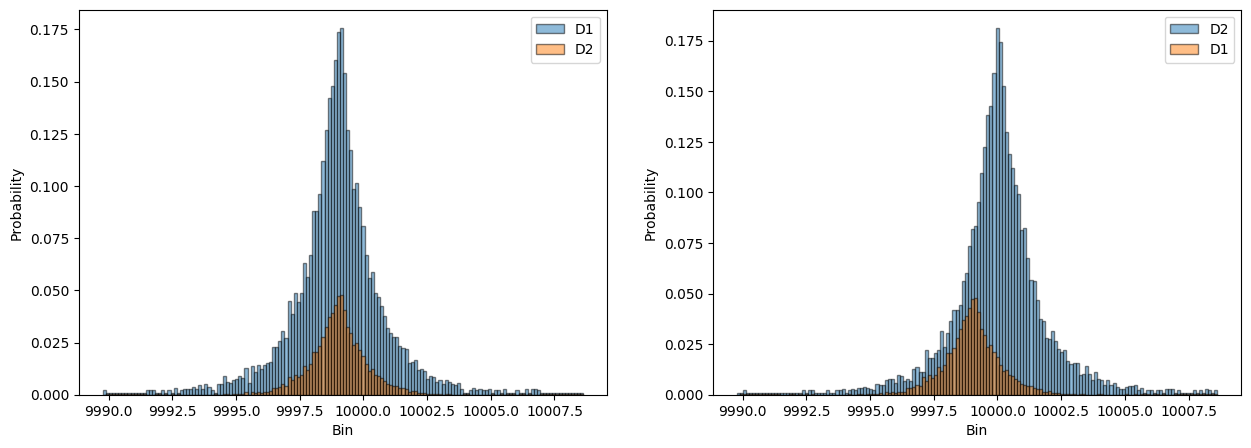

In [17]:
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Laplace mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.120838808645  Stdev fD1:  17.111257616450168  Mean fD2:  20010.20872859543  Stdev fD2:  17.24412859027192

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.1221, pvalue=2.4891143802376325e-65) 

Wasserstein Distance:  2.520408163265303 

DP Predicate Test: True 



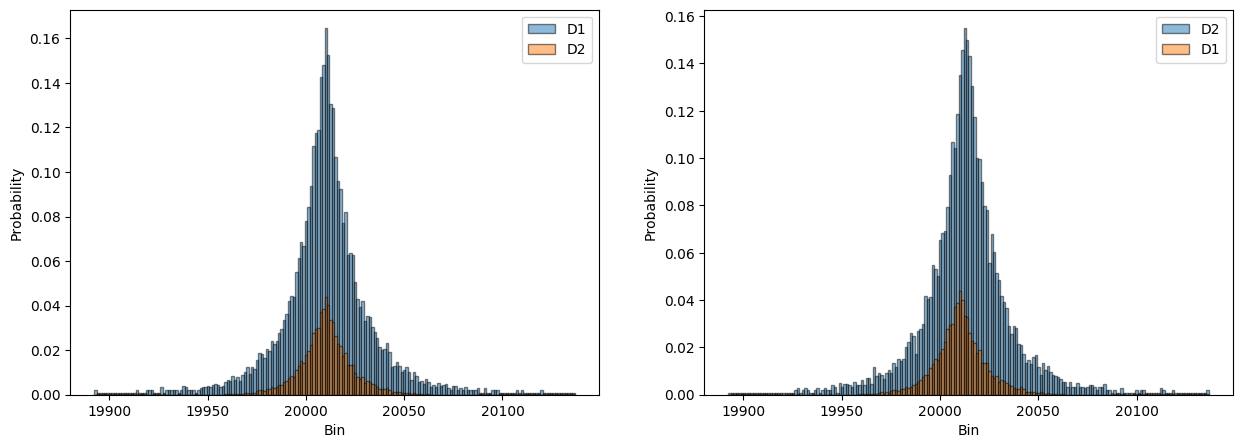

In [18]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

#### Gaussian mechanism - Count

Length of D1:  10000  Length of D2:  9999
Mean fD1:  10000.160569315138  Stdev fD1:  8.713281374200593  Mean fD2:  9999.063836061421  Stdev fD2:  8.651071444912692

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.052, pvalue=3.5727044438965934e-12) 

Wasserstein Distance:  4.719101123595506 

DP Predicate Test: True 



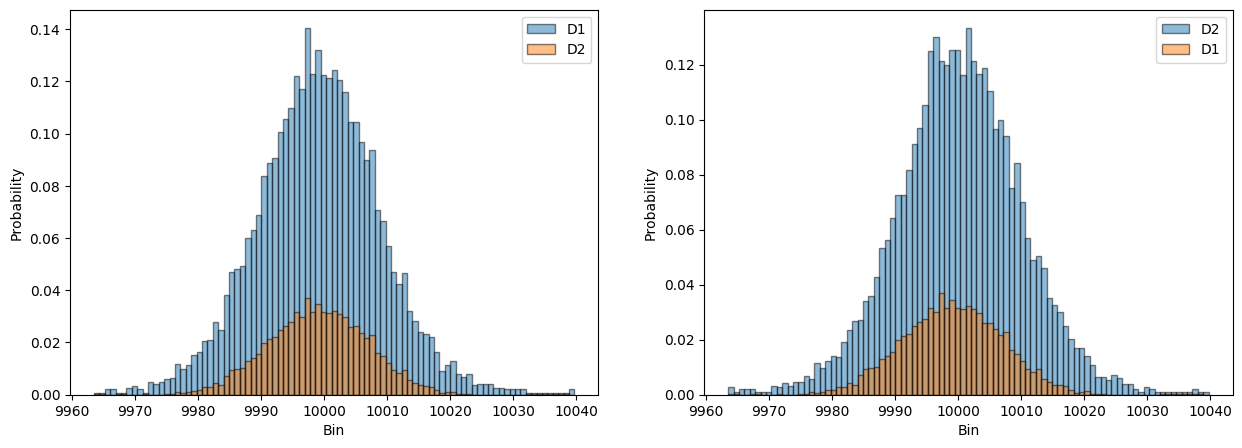

In [19]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Gaussian")
dp_count, ks_count, ws_count = dv.aggtest(ag.dp_mechanism_count, 'UserId', binsize="auto", debug = False)

#### Gaussian Mechanism - SUM

Length of D1:  10000  Length of D2:  9999
Mean fD1:  20013.07385848174  Stdev fD1:  8.644544652112666  Mean fD2:  20011.987360761195  Stdev fD2:  8.72405545237802

KS 2-sample Test Result:  Ks_2sampResult(statistic=0.0573, pvalue=1.0833872553773076e-14) 

Wasserstein Distance:  4.74074074074074 

DP Predicate Test: True 



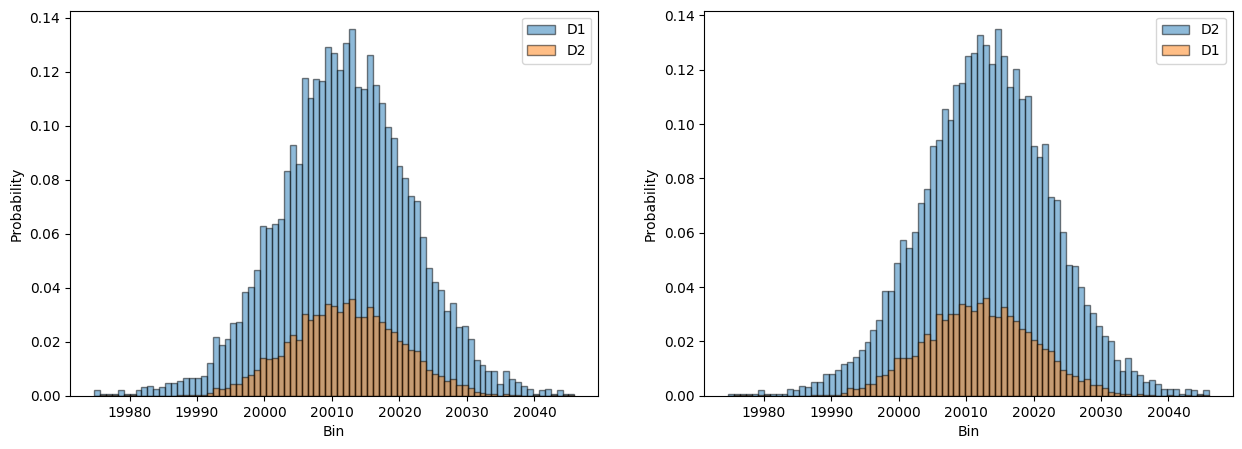

In [20]:
dp_sum, ks_sum, ws_sum = dv.aggtest(ag.dp_mechanism_sum, 'Usage', binsize="auto", debug=False)

### Verifying Whitenoise-System Private Query implementation for a sample query

#### Note: Whitenoise-System uses Laplace noise by default right now but has support for both Laplace and Gaussian noise

### SUM DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  -0.0005178633887972818
p-Value of 1 sample t-test:  0.11879313579439382


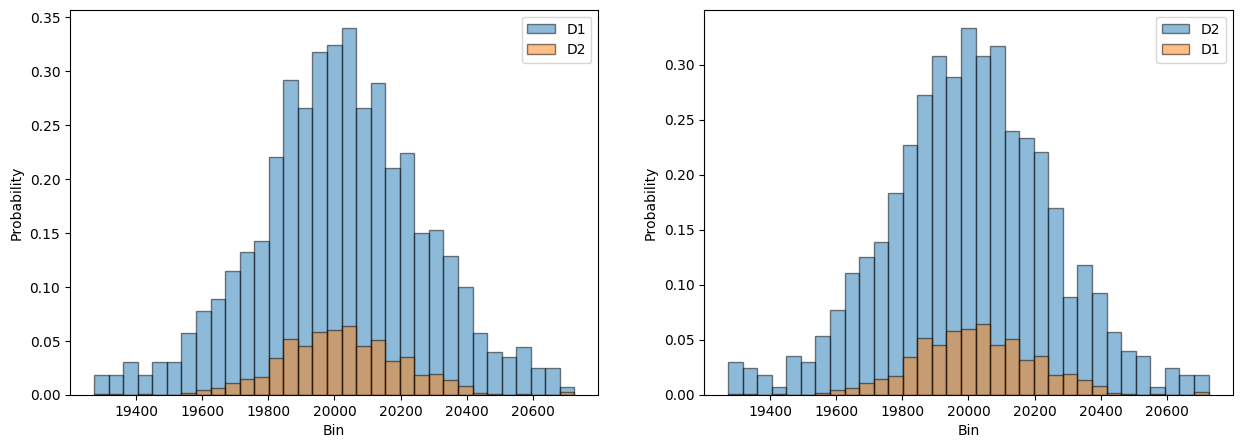

DP Predicate Test:  True
Bias Test:  True
--- 55.2279589176178 seconds ---


In [21]:
ag = agg.Aggregation(t=1, repeat_count=10000, mechanism = "Laplace")
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT SUM(Usage) AS TotalUsage FROM d1.d1"
d2_query = "SELECT SUM(Usage) AS TotalUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### COUNT DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  -5.13e-05
p-Value of 1 sample t-test:  0.04776644295076324


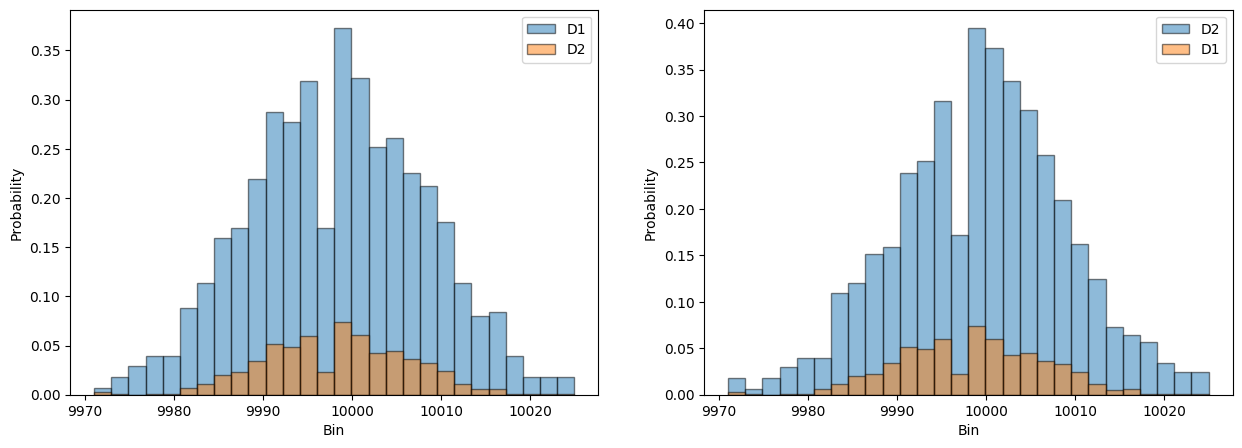

DP Predicate Test:  True
Bias Test:  False
--- 44.488341093063354 seconds ---


In [22]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d1.d1"
d2_query = "SELECT COUNT(UserId) AS TotalUserCount FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### MEAN DP Predicate Test

Length of D1:  10000  Length of D2:  9999
Mean signed deviation ratio to actual:  -0.00014796105097553575
p-Value of 1 sample t-test:  0.6570195298693018


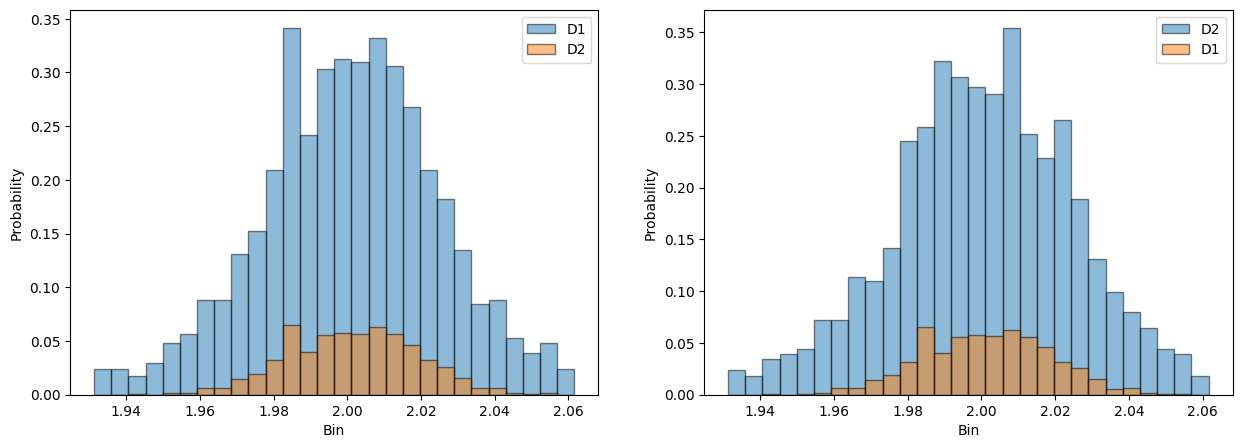

DP Predicate Test:  True
Bias Test:  True
--- 63.51594519615173 seconds ---


In [23]:
start_time = time.time()
# Applying same query on neighboring datasets
d1_query = "SELECT AVG(Usage) AS AvgUsage FROM d1.d1"
d2_query = "SELECT AVG(Usage) AS AvgUsage FROM d2.d2"
dp_res, acc_res, utility_res, bias_res = dv.dp_query_test(d1_query, d2_query, plot=True, repeat_count=1000)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))

### Powerset Test

Test case:  [0.0, -333.33333333333337, -600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.6584815068488417
p-Value of 1 sample t-test:  0.08430542878141548
DP Predicate Test Result:  True


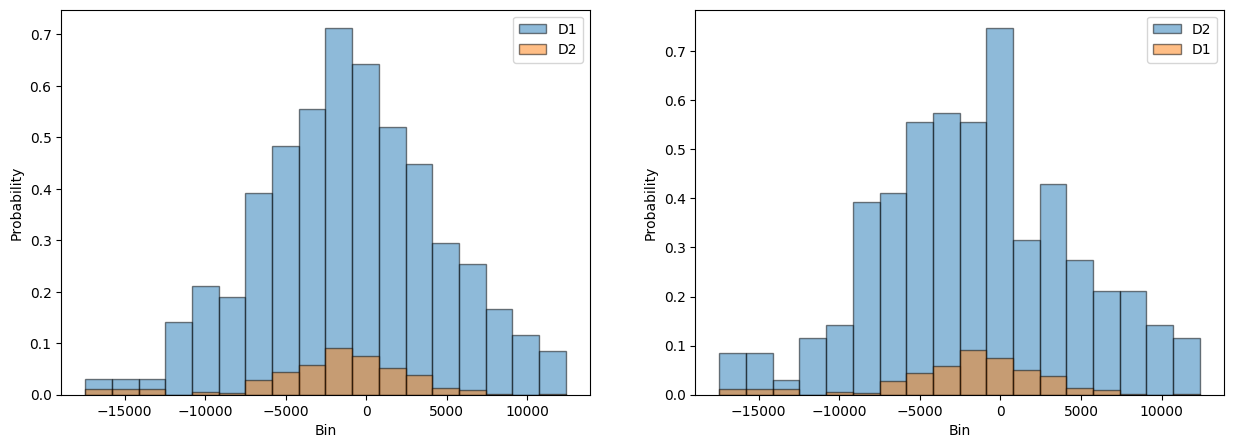

Testing:  12_1
Mean signed deviation ratio to actual:  -0.07585048566579554
p-Value of 1 sample t-test:  0.8412049423109619
DP Predicate Test Result:  True


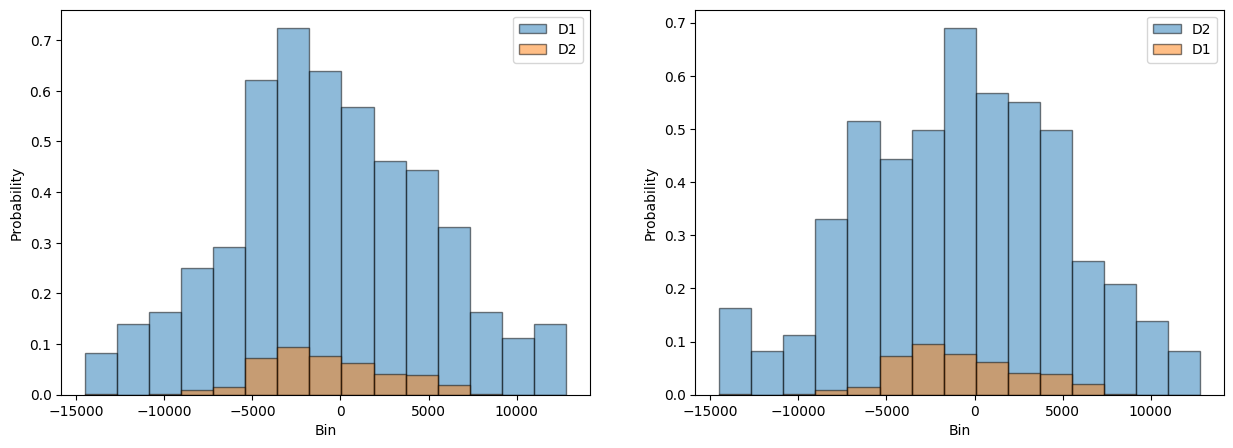

Testing:  2_2
Mean signed deviation ratio to actual:  -0.1165127211475877
p-Value of 1 sample t-test:  0.8368595911110496
DP Predicate Test Result:  True


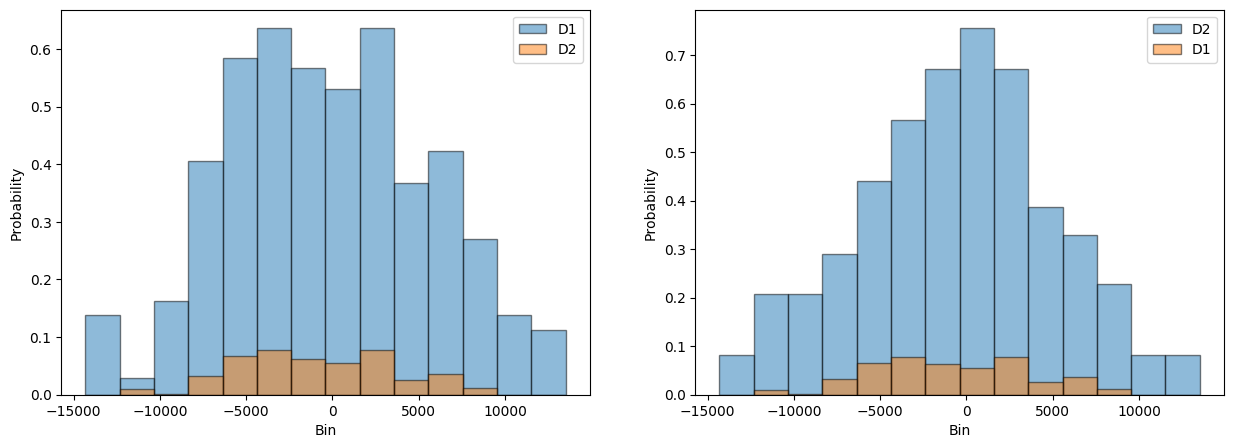

Testing:  12_2
Mean signed deviation ratio to actual:  0.0798854113832683
p-Value of 1 sample t-test:  0.8290703417496246
DP Predicate Test Result:  True


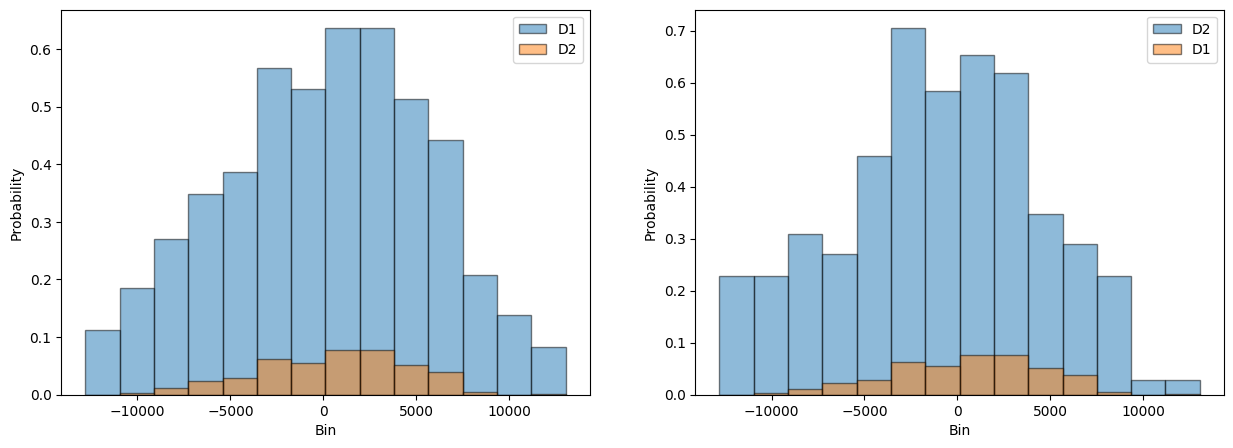

Testing:  1_1
Mean signed deviation ratio to actual:  -1.7824368672351085
p-Value of 1 sample t-test:  0.003256828573364275
DP Predicate Test Result:  True


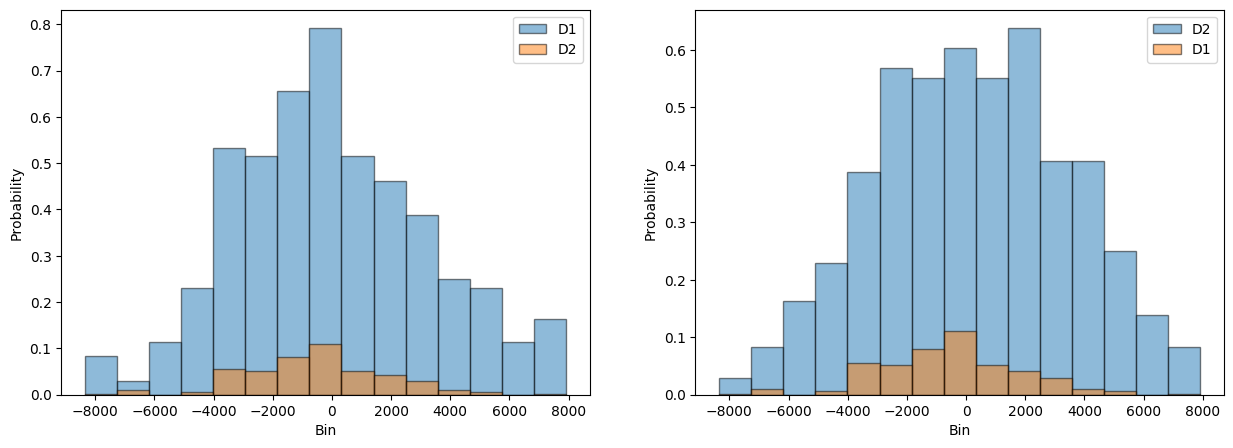

Testing:  012_1
Mean signed deviation ratio to actual:  0.02532448207524416
p-Value of 1 sample t-test:  0.9484231371144917
DP Predicate Test Result:  True


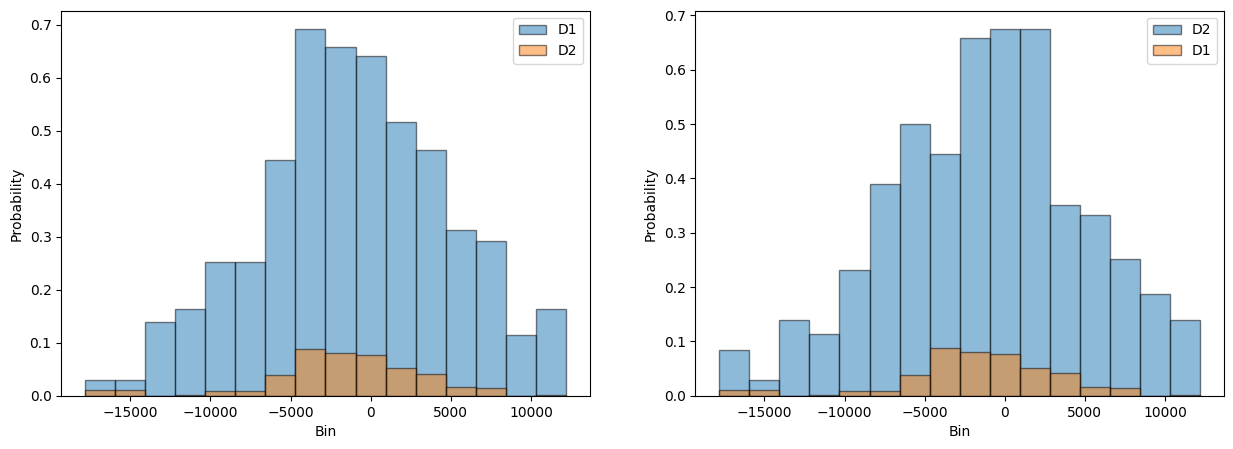

Testing:  02_0
Mean signed deviation ratio to actual:  0.7813199821994484
p-Value of 1 sample t-test:  0.2119059096468444
DP Predicate Test Result:  True


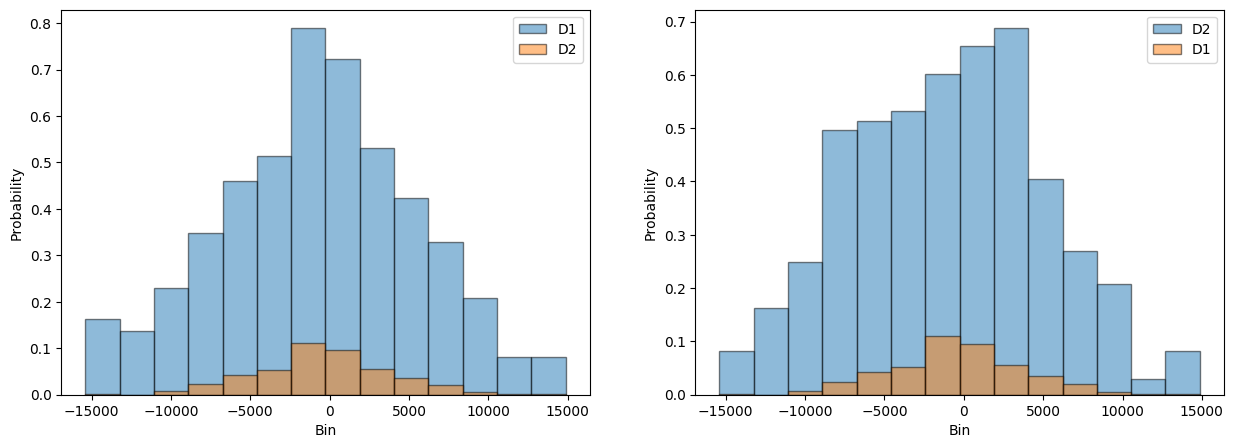

Testing:  02_2
Mean signed deviation ratio to actual:  -0.2862865632137339
p-Value of 1 sample t-test:  0.6427117077105876
DP Predicate Test Result:  True


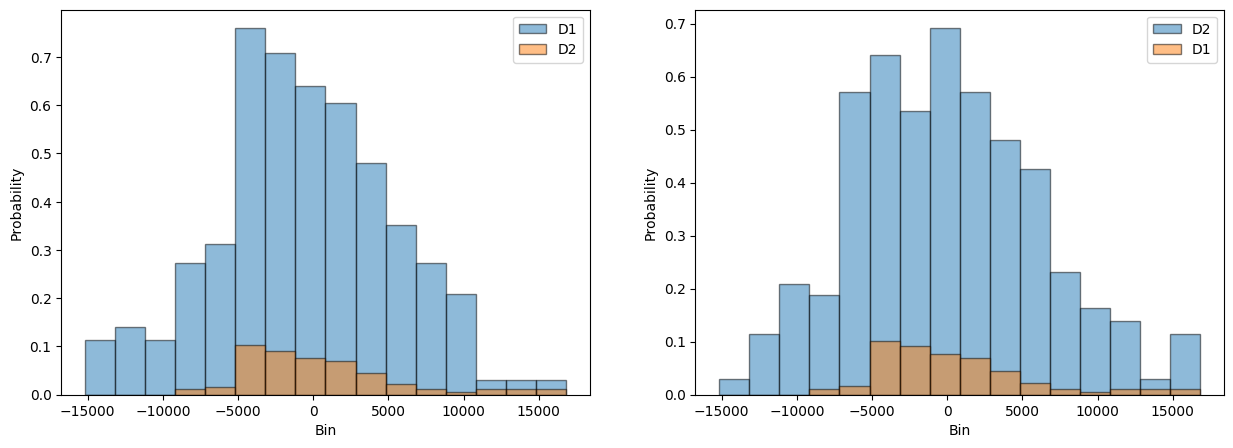

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


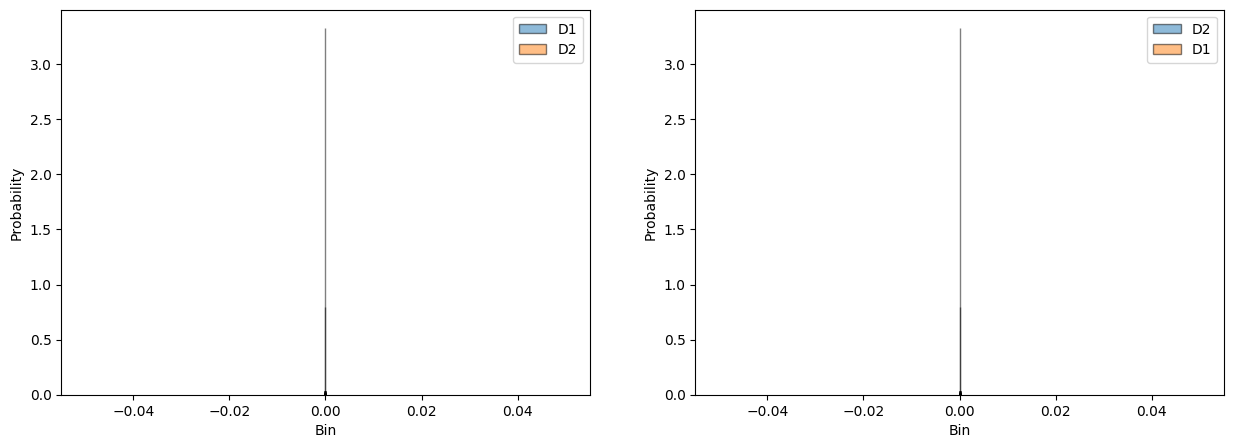

Testing:  012_2
Mean signed deviation ratio to actual:  -0.041403931888358954
p-Value of 1 sample t-test:  0.9081283588302488
DP Predicate Test Result:  True


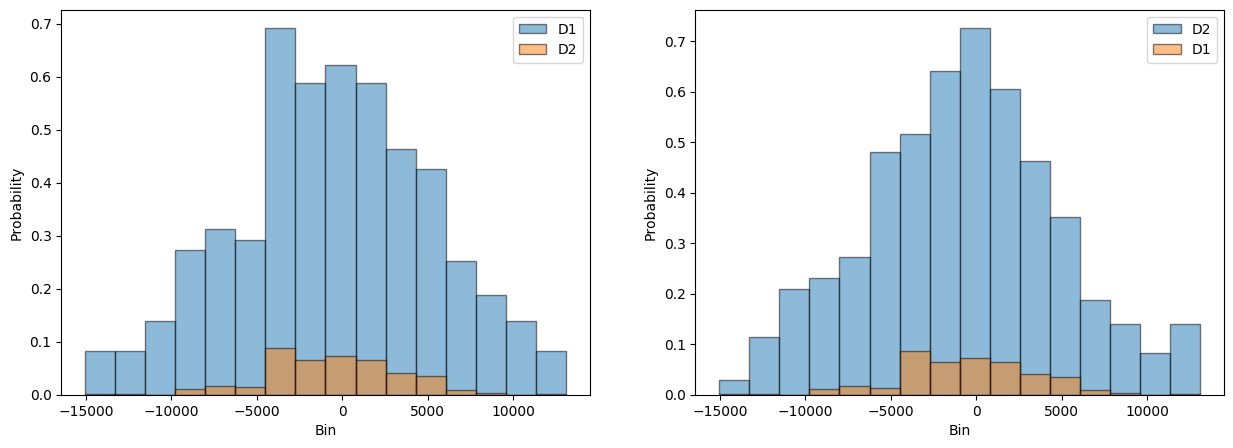

Testing:  01_0
Mean signed deviation ratio to actual:  -0.7030675669907334
p-Value of 1 sample t-test:  0.16357475036166802
DP Predicate Test Result:  True


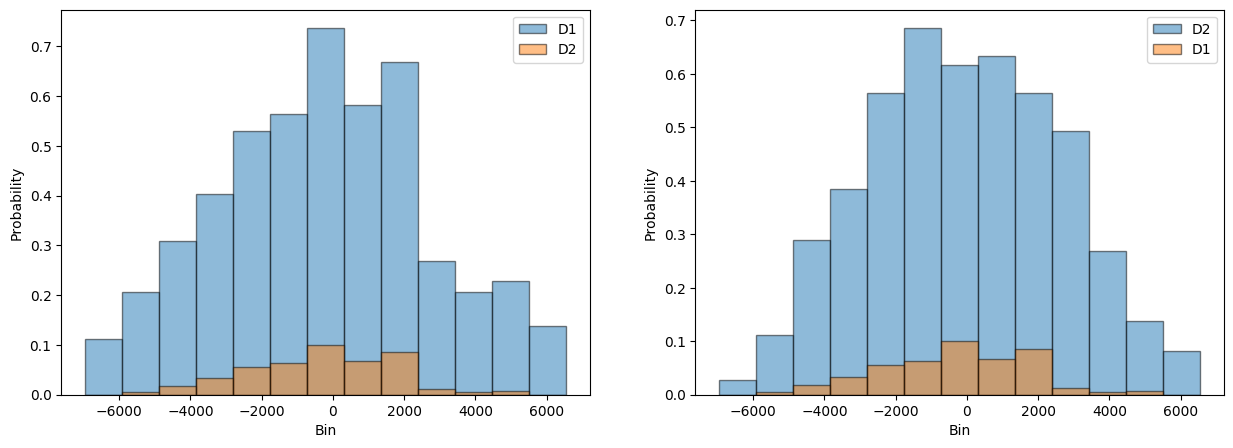

Testing:  01_1
Mean signed deviation ratio to actual:  -0.1831299105734209
p-Value of 1 sample t-test:  0.7555667603100211
DP Predicate Test Result:  True


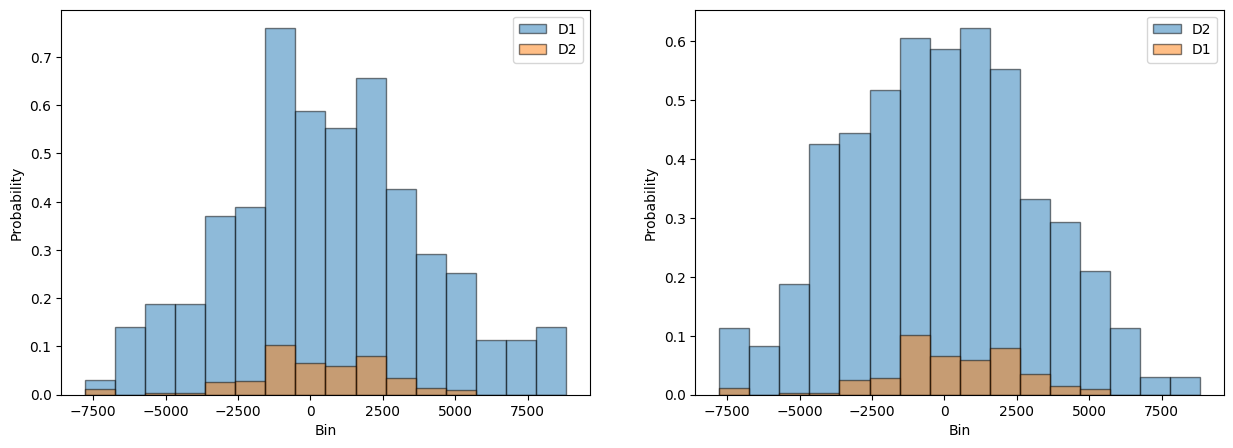

Test case:  [-500.0, 333.33333333333326, -200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.40172317016481734
p-Value of 1 sample t-test:  0.2850035263542852
DP Predicate Test Result:  True


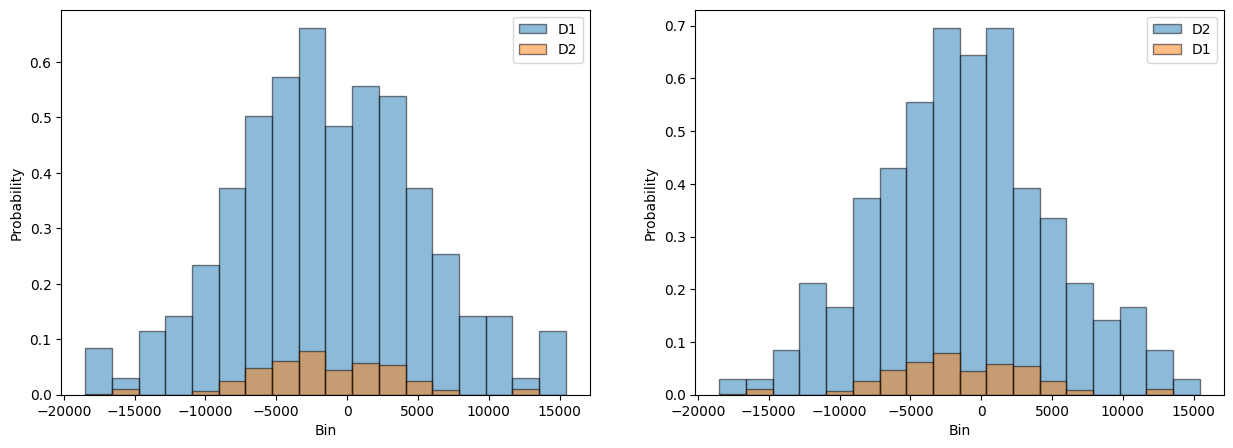

Testing:  12_1
Mean signed deviation ratio to actual:  0.05773679953696286
p-Value of 1 sample t-test:  0.8773493118034257
DP Predicate Test Result:  True


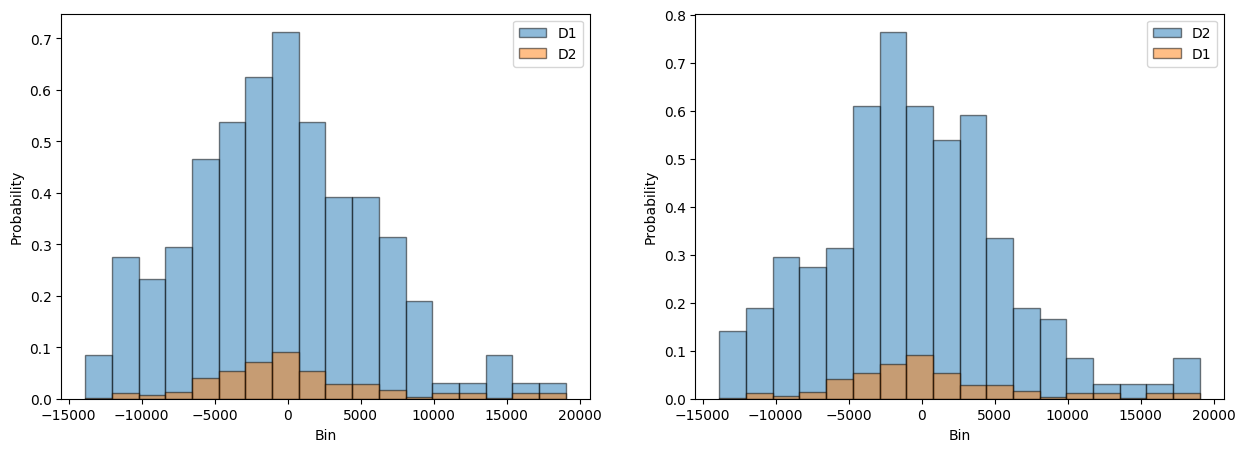

Testing:  2_2
Mean signed deviation ratio to actual:  -0.44639889055248594
p-Value of 1 sample t-test:  0.4534004308653221
DP Predicate Test Result:  True


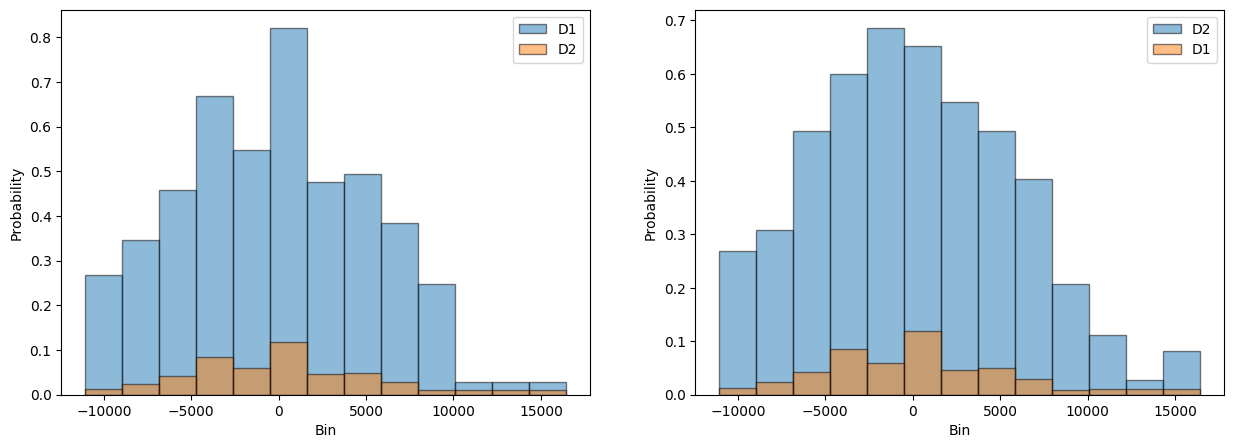

Testing:  12_2
Mean signed deviation ratio to actual:  -0.583242103936135
p-Value of 1 sample t-test:  0.1191149409243839
DP Predicate Test Result:  True


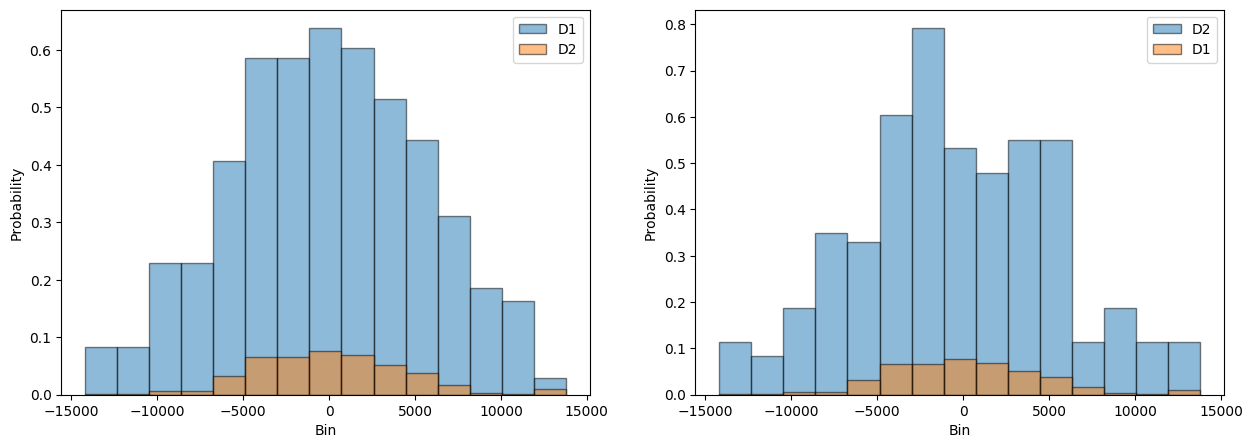

Testing:  1_1
Mean signed deviation ratio to actual:  -1.978918571076192
p-Value of 1 sample t-test:  0.0014761293499847101
DP Predicate Test Result:  True


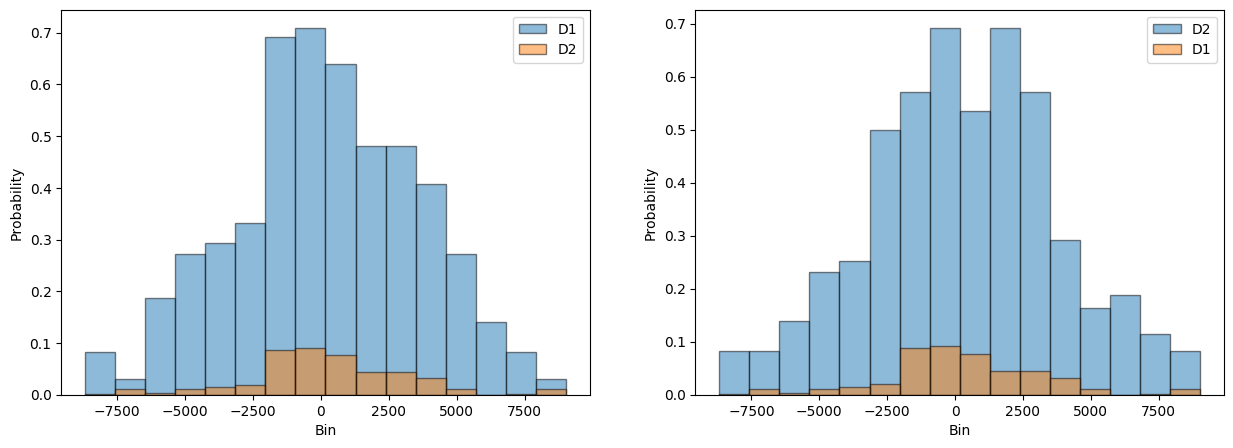

Testing:  012_1
Mean signed deviation ratio to actual:  -0.12197758421051907
p-Value of 1 sample t-test:  0.7449712496861538
DP Predicate Test Result:  True


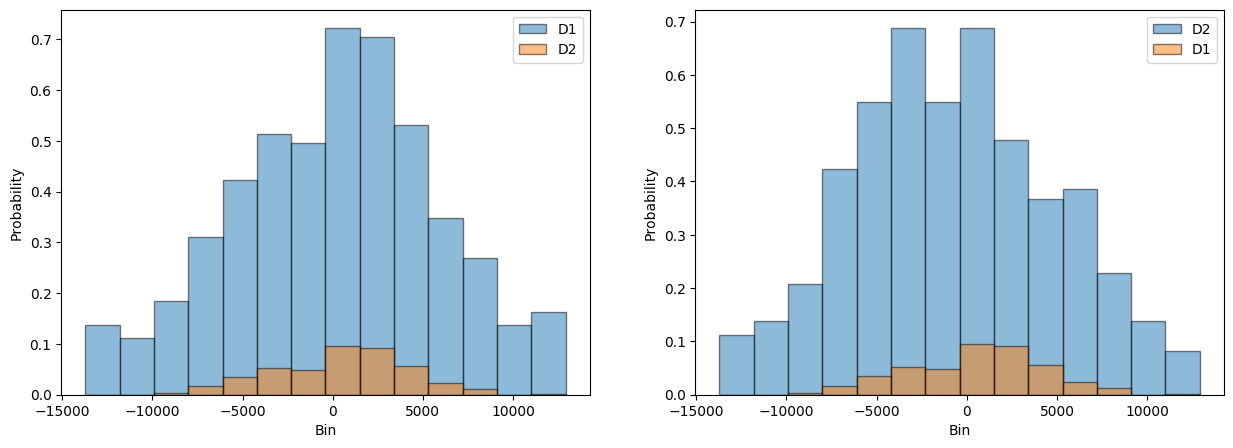

Testing:  02_0
Mean signed deviation ratio to actual:  -1.0484942571034082
p-Value of 1 sample t-test:  0.06018336411932258
DP Predicate Test Result:  True


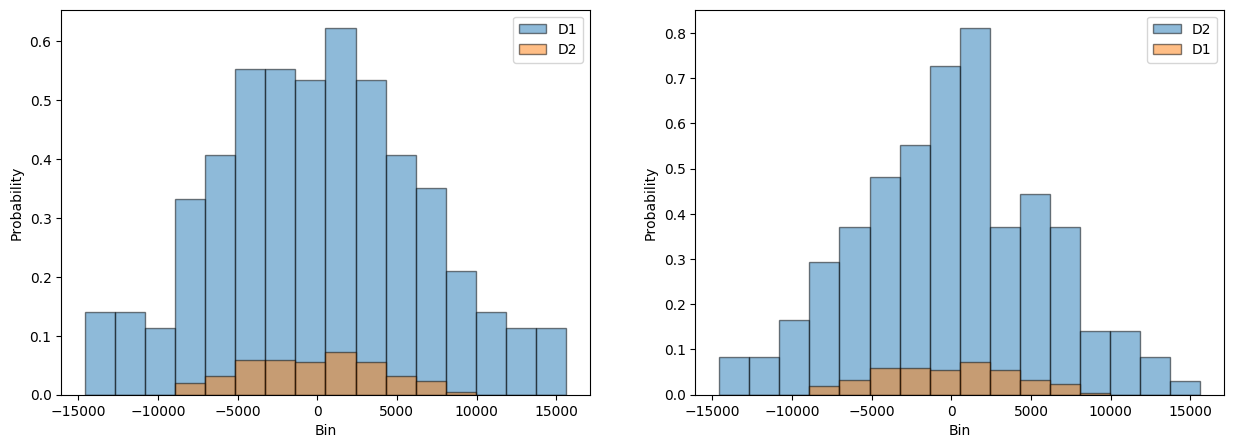

Testing:  02_2
Mean signed deviation ratio to actual:  0.2836757676336148
p-Value of 1 sample t-test:  0.6185673470023048
DP Predicate Test Result:  True


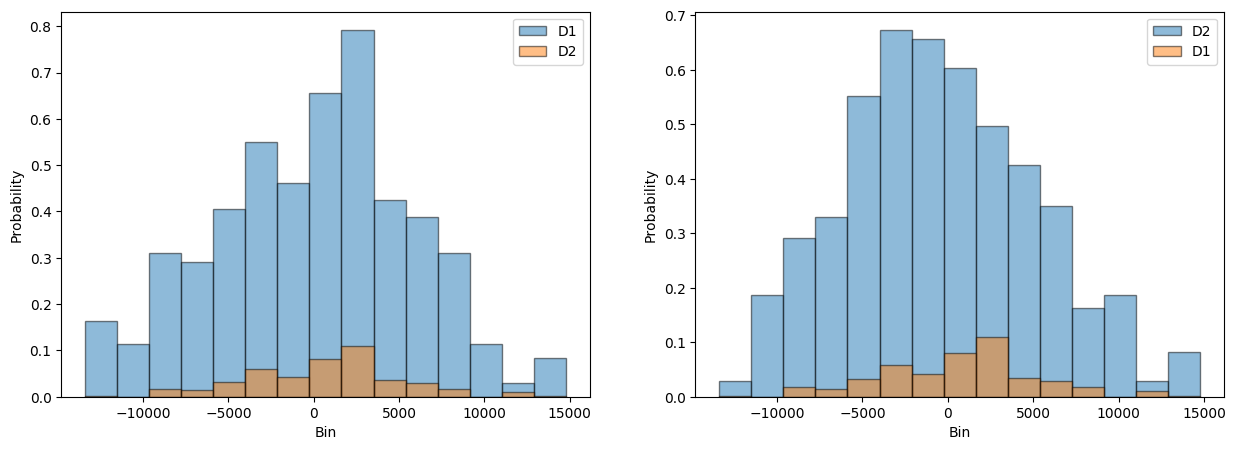

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


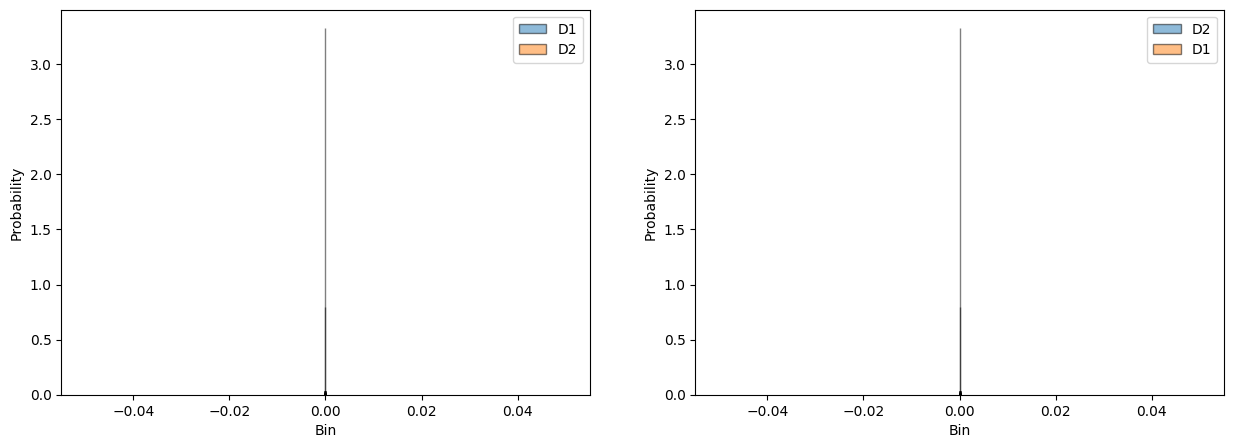

Testing:  012_2
Mean signed deviation ratio to actual:  -0.08380038992341433
p-Value of 1 sample t-test:  0.8231462446874698
DP Predicate Test Result:  True


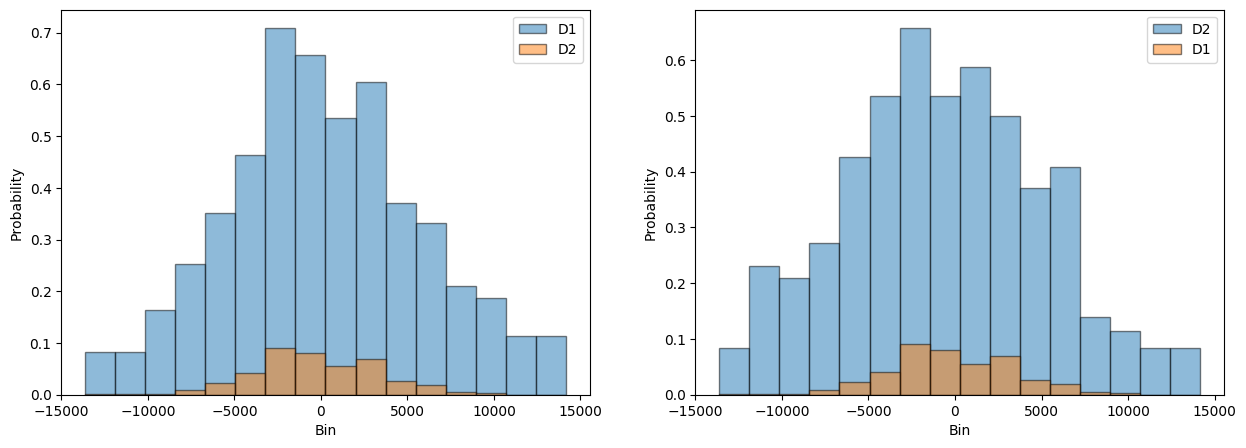

Testing:  01_0
Mean signed deviation ratio to actual:  0.3438083663729765
p-Value of 1 sample t-test:  0.5934860391020556
DP Predicate Test Result:  True


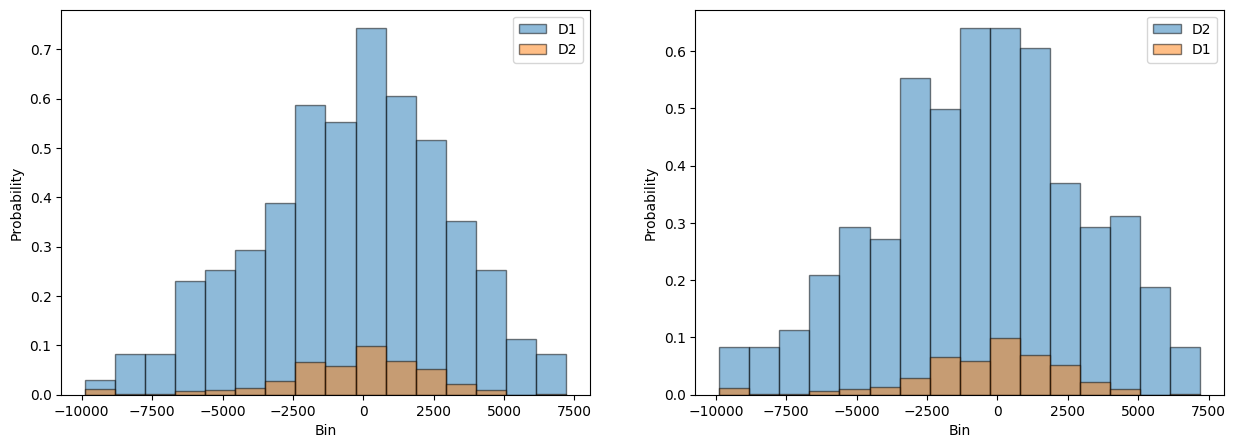

Testing:  01_1
Mean signed deviation ratio to actual:  -0.46539786165779107
p-Value of 1 sample t-test:  0.4297004769575866
DP Predicate Test Result:  True


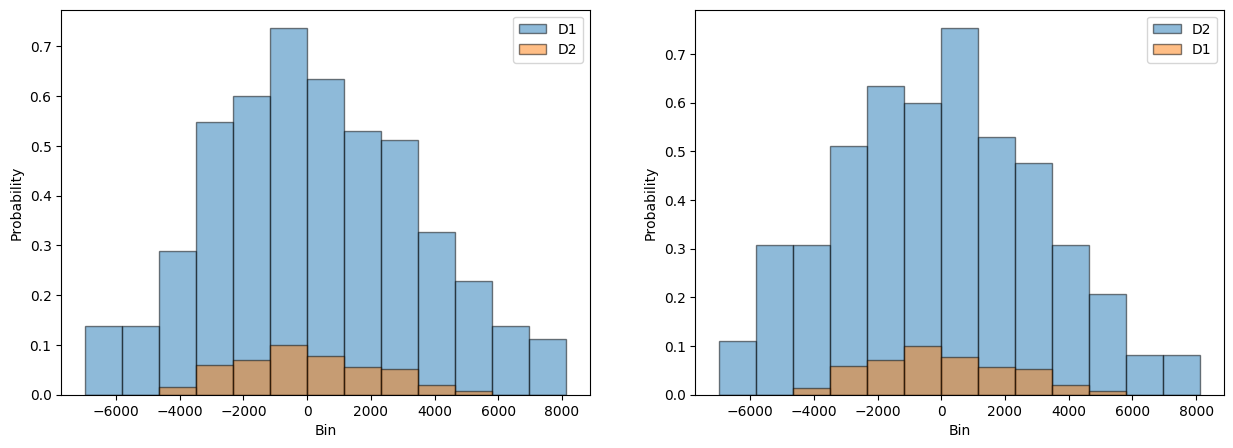

Test case:  [500.0, -777.7777777777778, 200.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.14353711467333768
p-Value of 1 sample t-test:  0.71478672660063
DP Predicate Test Result:  True


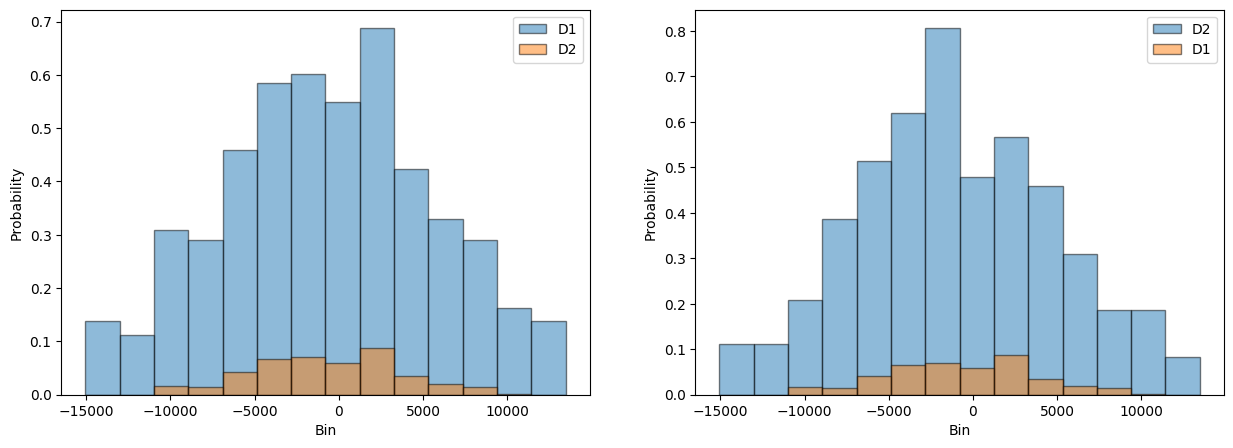

Testing:  12_1
Mean signed deviation ratio to actual:  0.4976701568877473
p-Value of 1 sample t-test:  0.17721535381701575
DP Predicate Test Result:  True


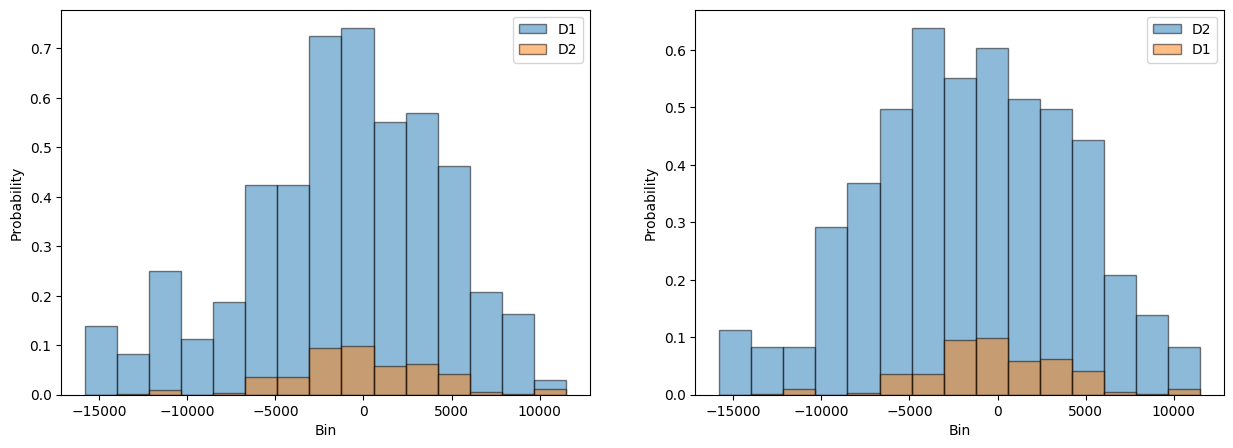

Testing:  2_2
Mean signed deviation ratio to actual:  -1.1701071264056444
p-Value of 1 sample t-test:  0.05901024161981732
DP Predicate Test Result:  True


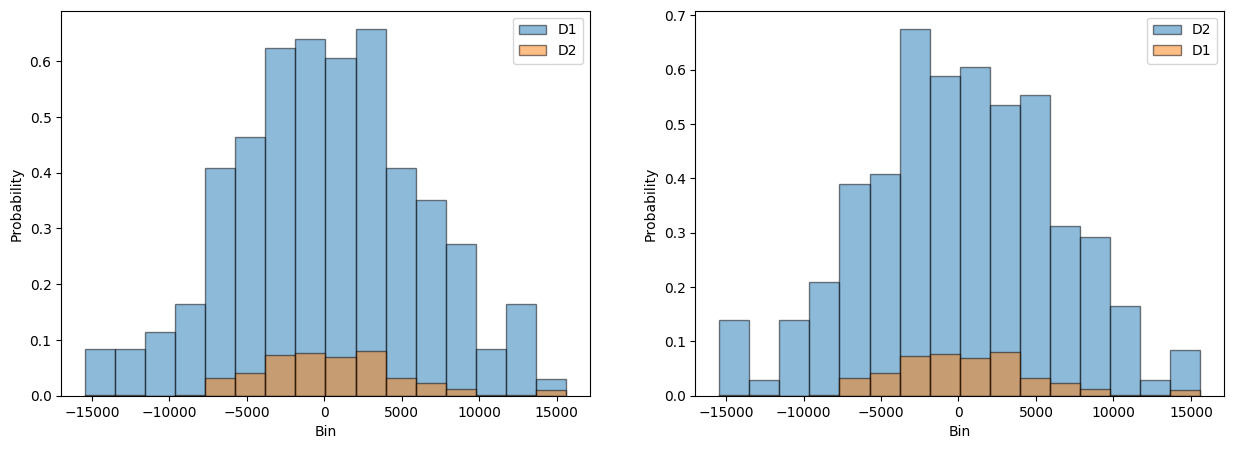

Testing:  12_2
Mean signed deviation ratio to actual:  -0.010488605262096861
p-Value of 1 sample t-test:  0.9767899729564409
DP Predicate Test Result:  True


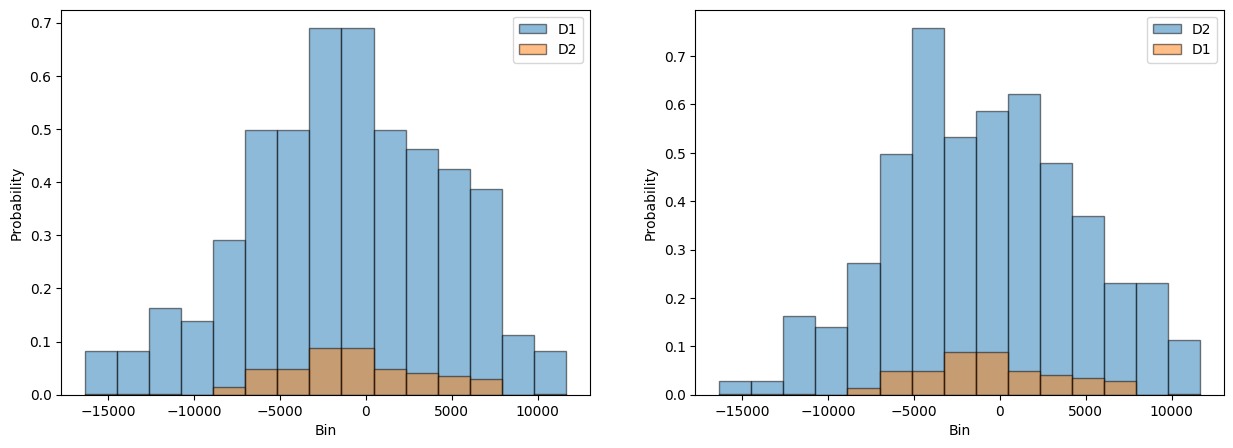

Testing:  1_1
Mean signed deviation ratio to actual:  -0.6894387438617058
p-Value of 1 sample t-test:  0.26047585177573584
DP Predicate Test Result:  True


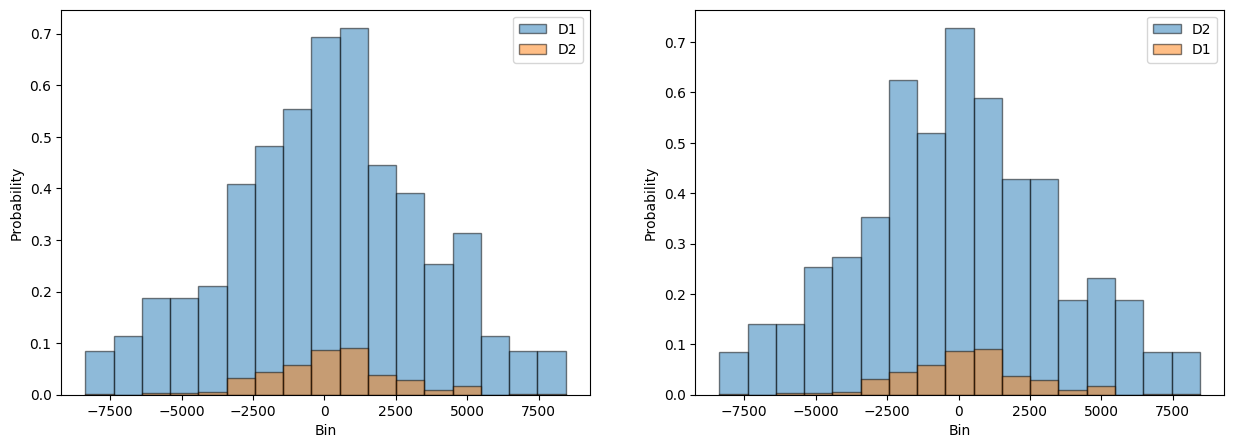

Testing:  012_1
Mean signed deviation ratio to actual:  -0.5865228827467325
p-Value of 1 sample t-test:  0.09590897868054137
DP Predicate Test Result:  True


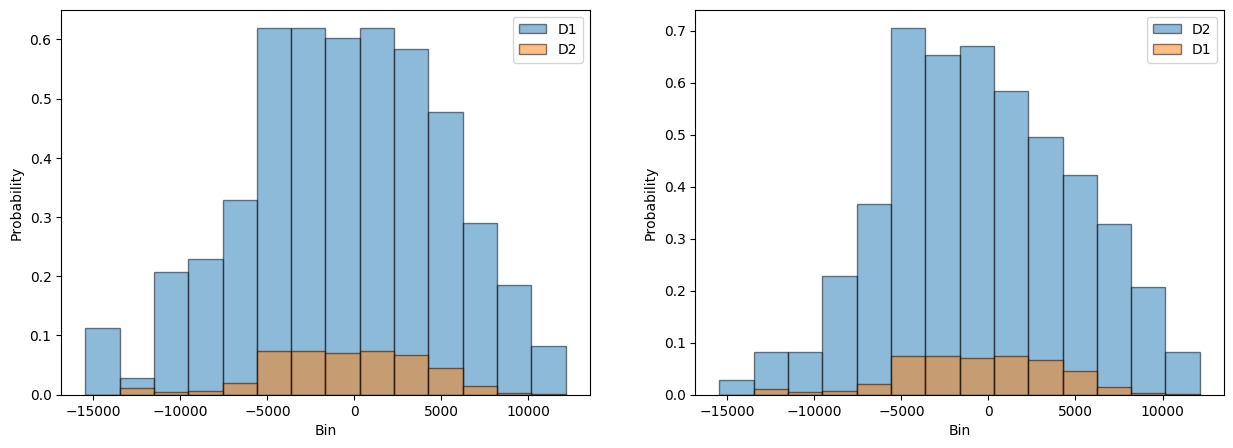

Testing:  02_0
Mean signed deviation ratio to actual:  0.8790862418477671
p-Value of 1 sample t-test:  0.1261400303043918
DP Predicate Test Result:  True


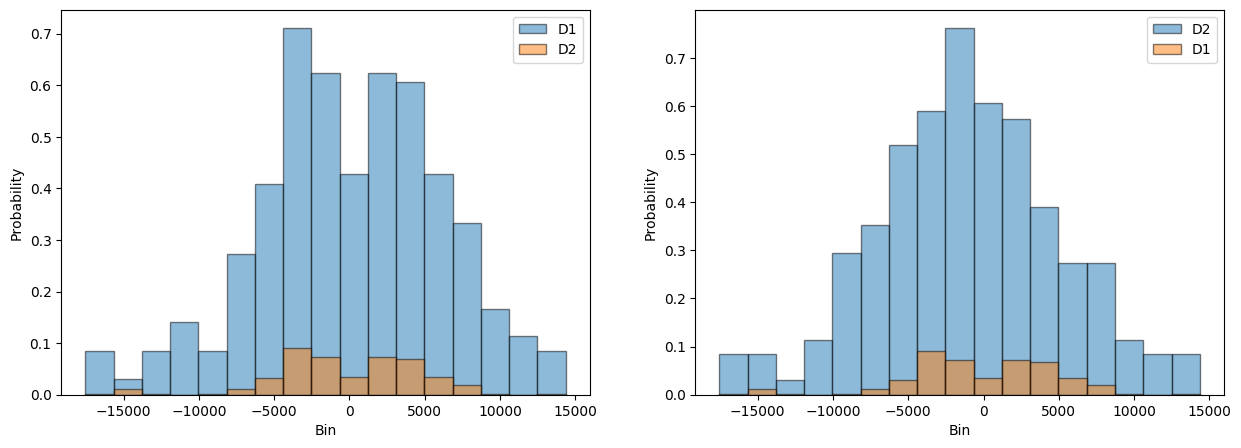

Testing:  02_2
Mean signed deviation ratio to actual:  0.3123489959163482
p-Value of 1 sample t-test:  0.6055584958688616
DP Predicate Test Result:  True


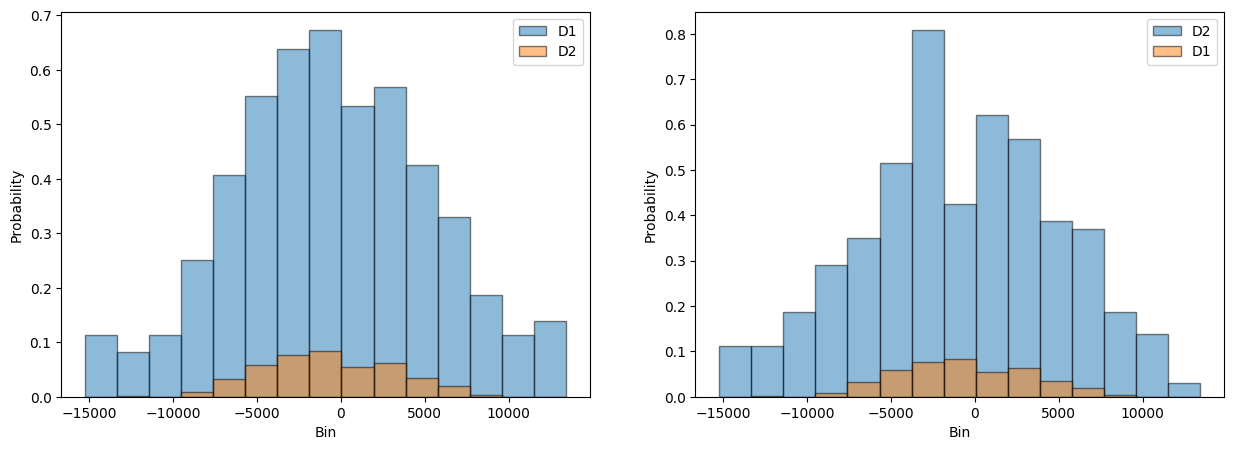

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


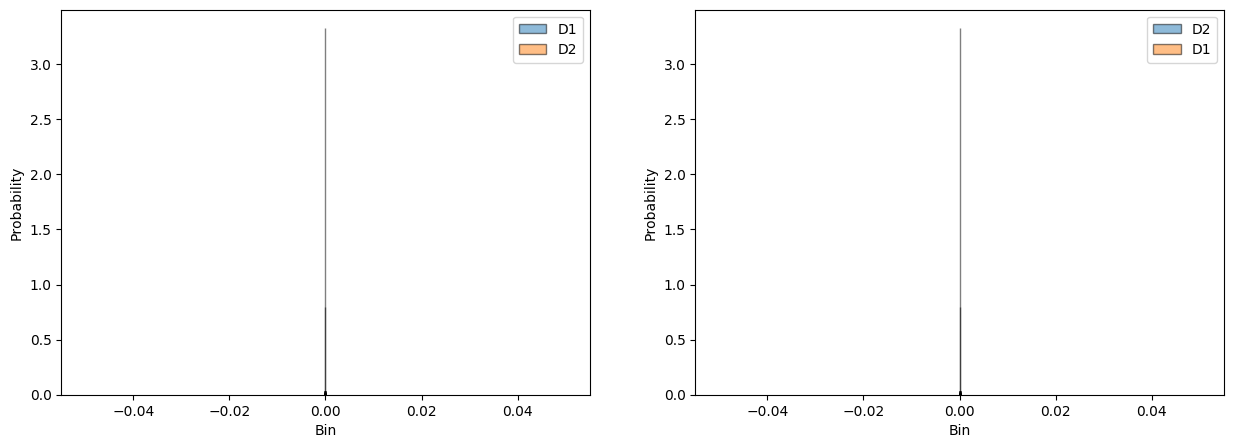

Testing:  012_2
Mean signed deviation ratio to actual:  0.7594204412912057
p-Value of 1 sample t-test:  0.05663916977745061
DP Predicate Test Result:  True


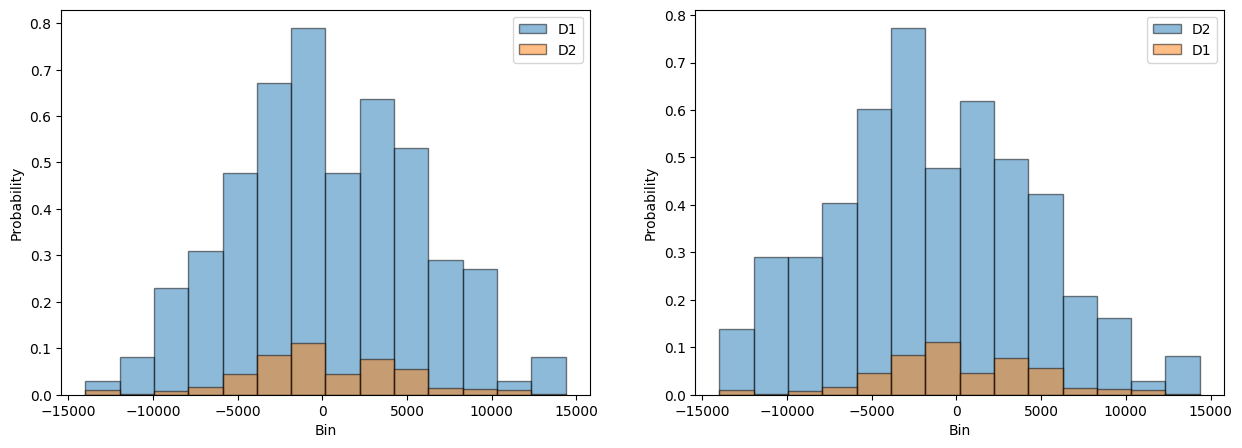

Testing:  01_0
Mean signed deviation ratio to actual:  -0.08567056915109349
p-Value of 1 sample t-test:  0.891531044279888
DP Predicate Test Result:  True


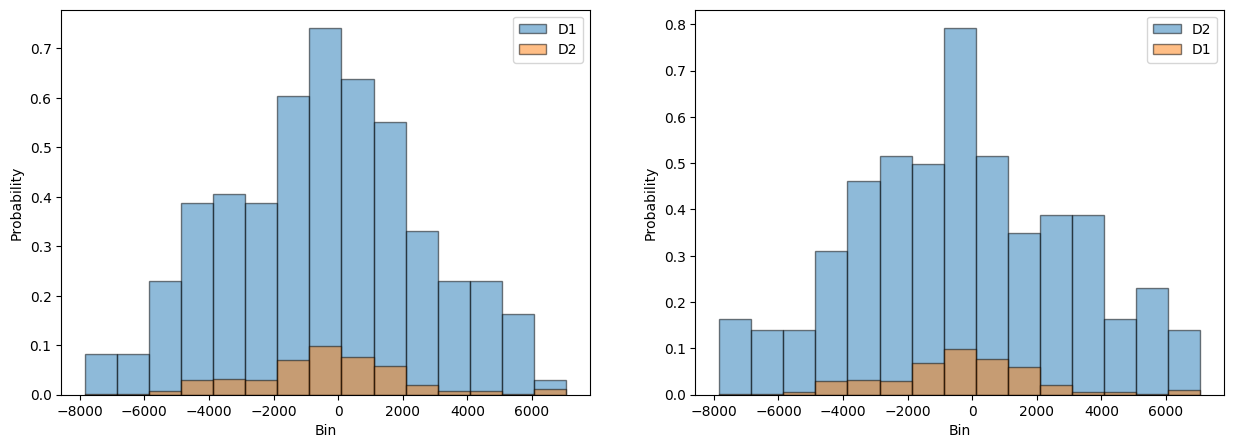

Testing:  01_1
Mean signed deviation ratio to actual:  -0.19721784127387343
p-Value of 1 sample t-test:  0.7347357839106056
DP Predicate Test Result:  True


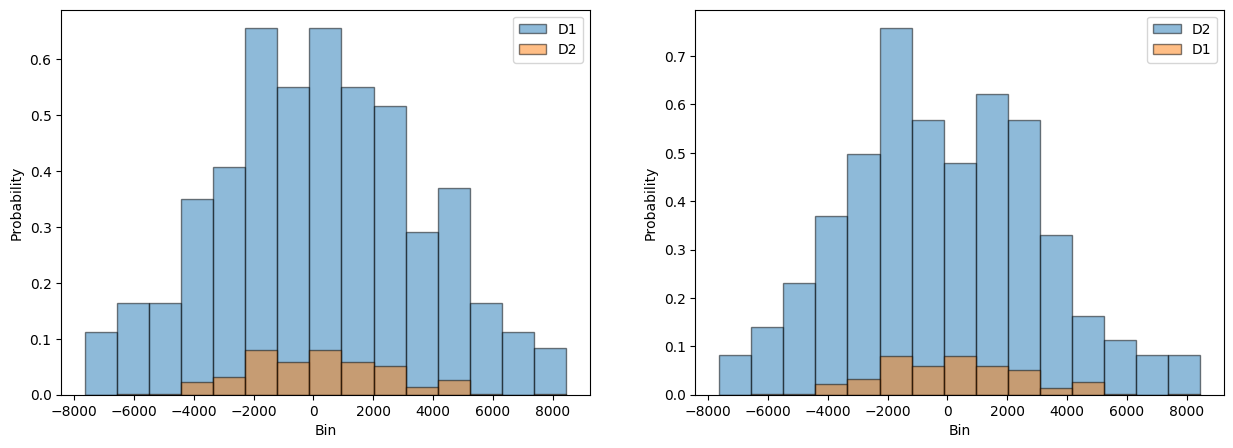

Test case:  [-750.0, -111.1111111111112, 600.0]
Testing:  012_0
Mean signed deviation ratio to actual:  0.1353384109440982
p-Value of 1 sample t-test:  0.7440648131075984
DP Predicate Test Result:  True


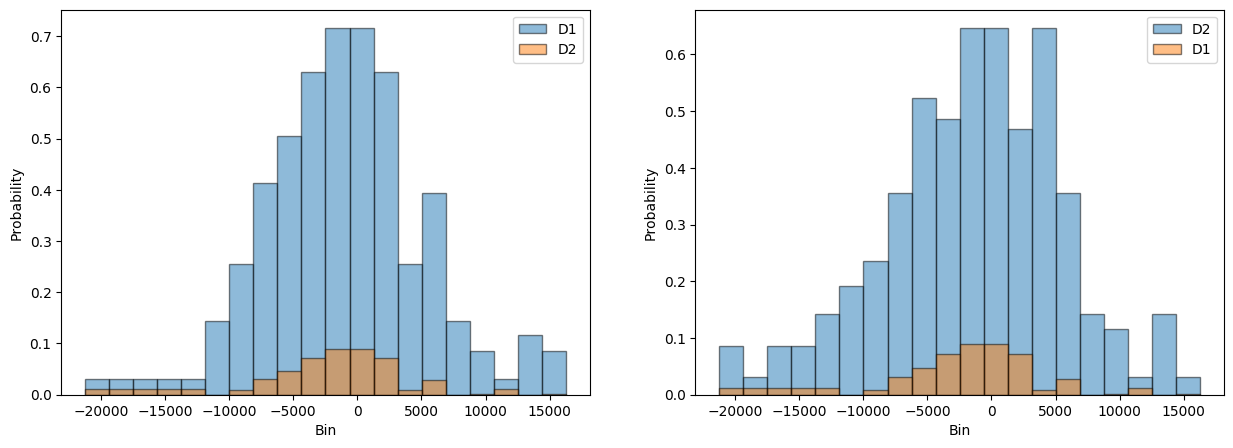

Testing:  12_1
Mean signed deviation ratio to actual:  -0.2592675264219111
p-Value of 1 sample t-test:  0.4729235958218799
DP Predicate Test Result:  True


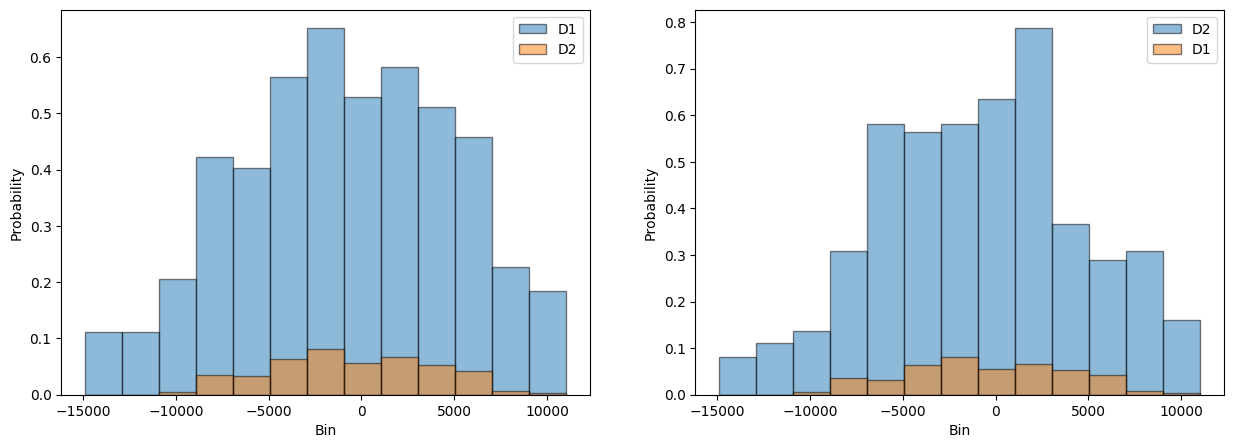

Testing:  2_2
Mean signed deviation ratio to actual:  -0.982173353371546
p-Value of 1 sample t-test:  0.12424591364515214
DP Predicate Test Result:  True


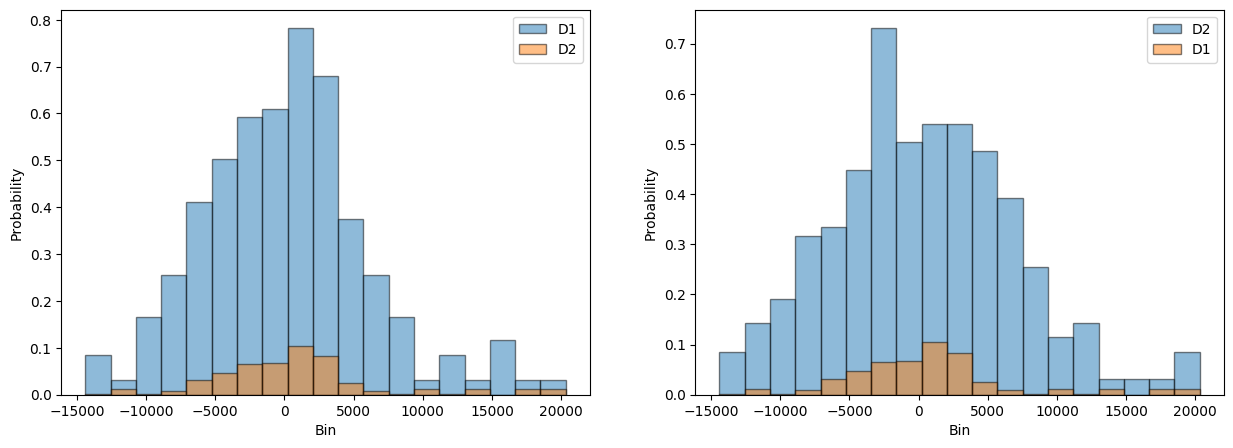

Testing:  12_2
Mean signed deviation ratio to actual:  0.20463352978662228
p-Value of 1 sample t-test:  0.6114172893924559
DP Predicate Test Result:  True


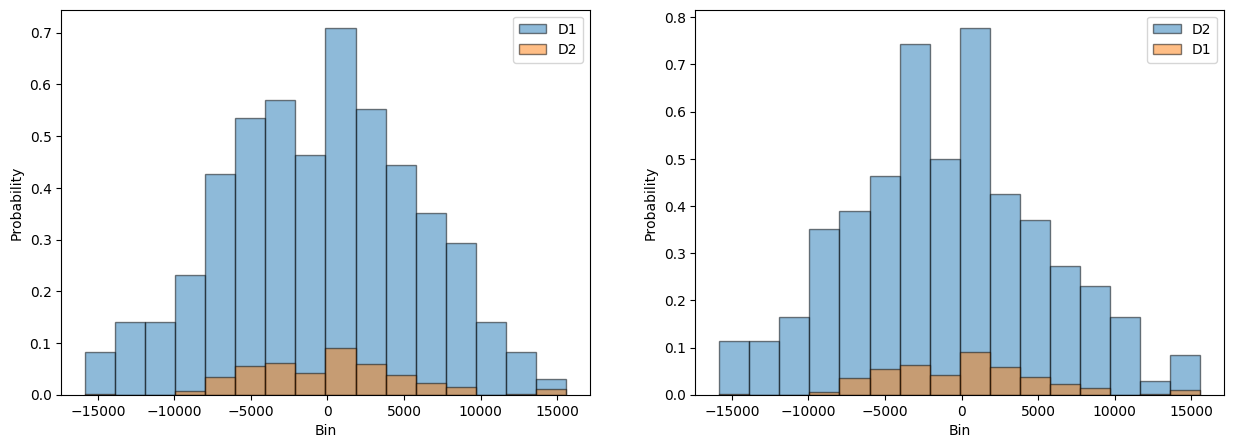

Testing:  1_1
Mean signed deviation ratio to actual:  -1.4584923277513826
p-Value of 1 sample t-test:  0.013353029950069897
DP Predicate Test Result:  True


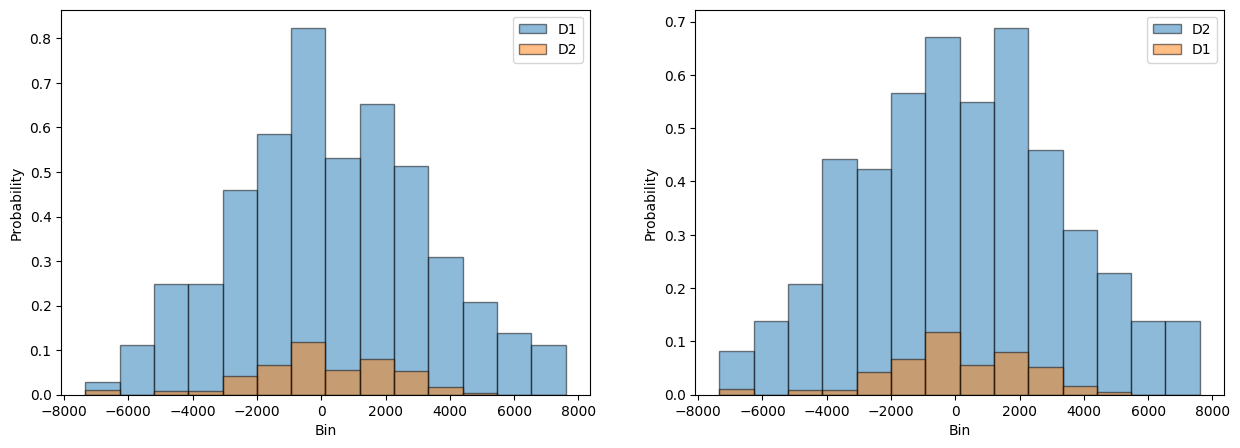

Testing:  012_1
Mean signed deviation ratio to actual:  0.21893744951895003
p-Value of 1 sample t-test:  0.5761114518360851
DP Predicate Test Result:  True


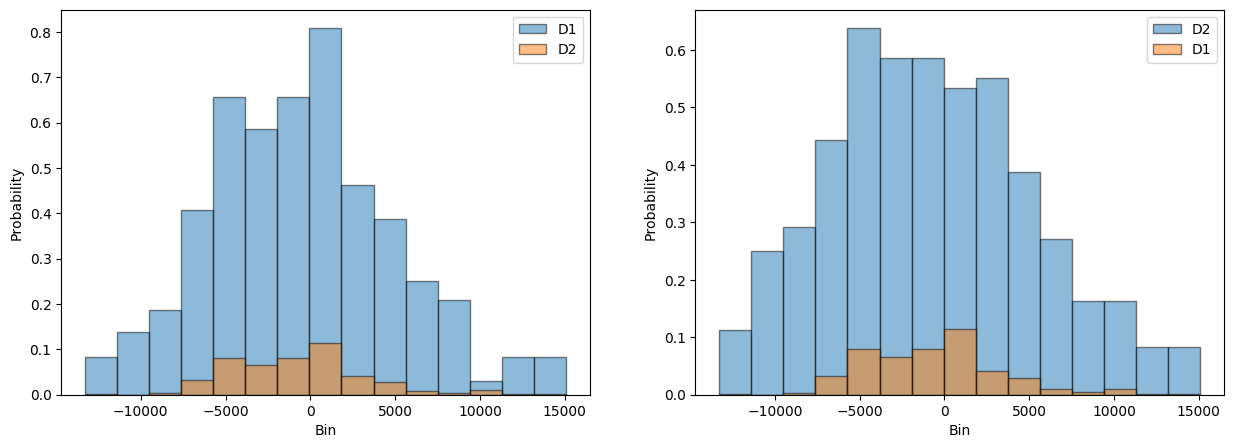

Testing:  02_0
Mean signed deviation ratio to actual:  -0.07579450887112464
p-Value of 1 sample t-test:  0.8971430492679499
DP Predicate Test Result:  True


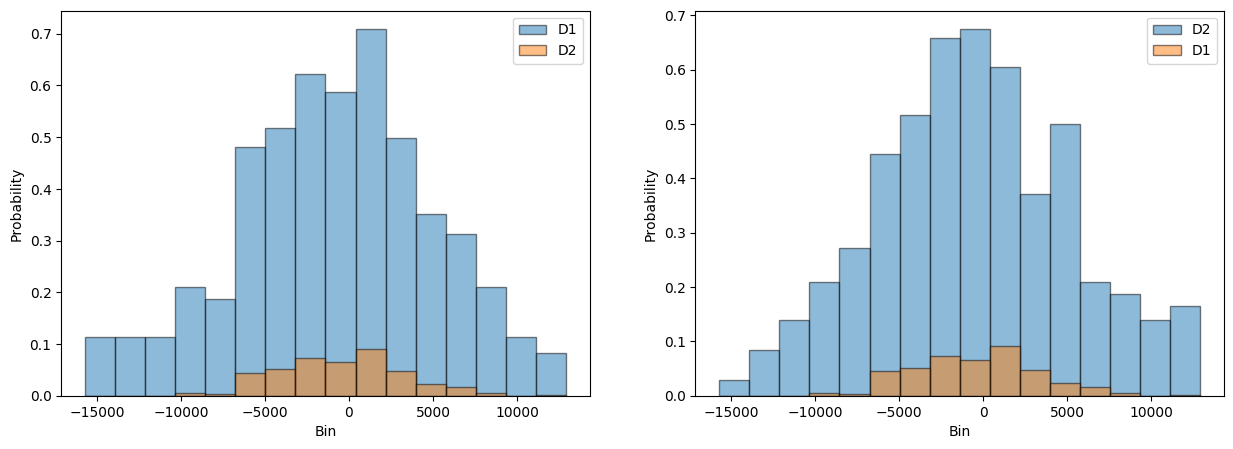

Testing:  02_2
Mean signed deviation ratio to actual:  0.3082865207987158
p-Value of 1 sample t-test:  0.6028271137394945
DP Predicate Test Result:  True


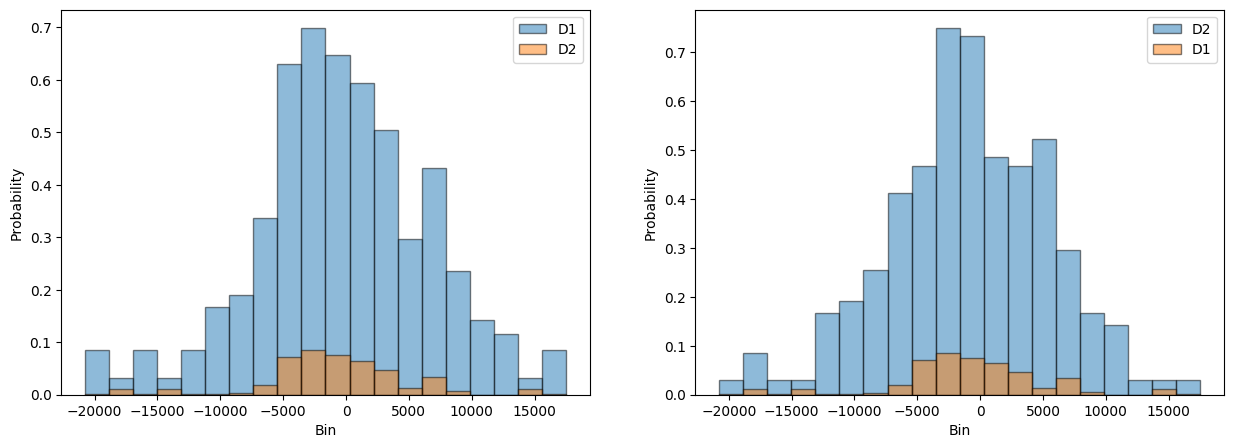

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


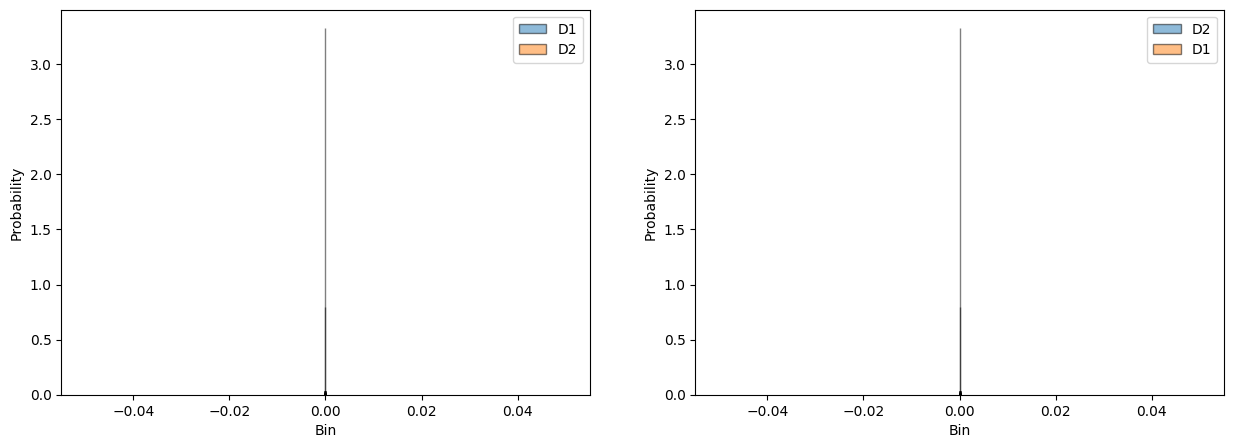

Testing:  012_2
Mean signed deviation ratio to actual:  -0.5215809264056434
p-Value of 1 sample t-test:  0.1410801615418313
DP Predicate Test Result:  True


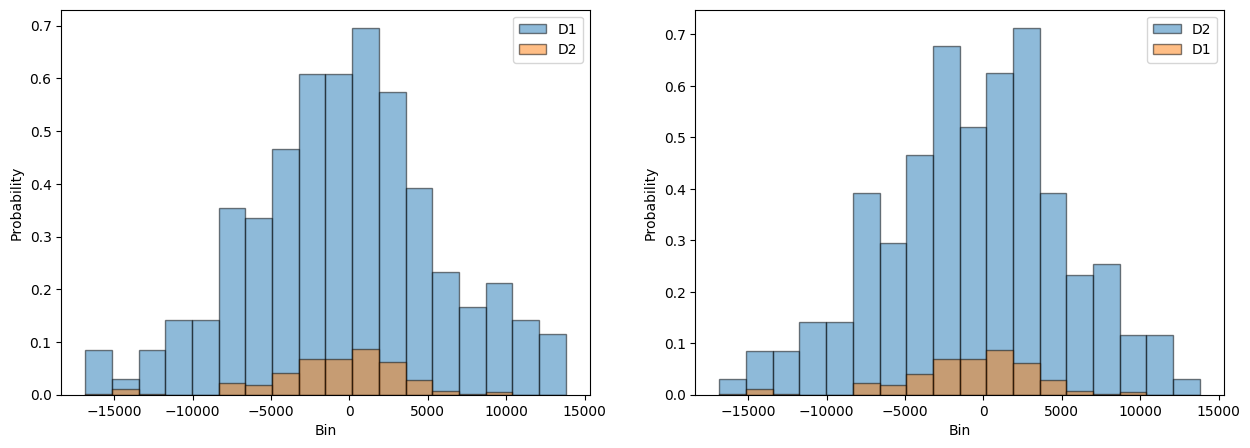

Testing:  01_0
Mean signed deviation ratio to actual:  0.39280659492126946
p-Value of 1 sample t-test:  0.5003138020020583
DP Predicate Test Result:  True


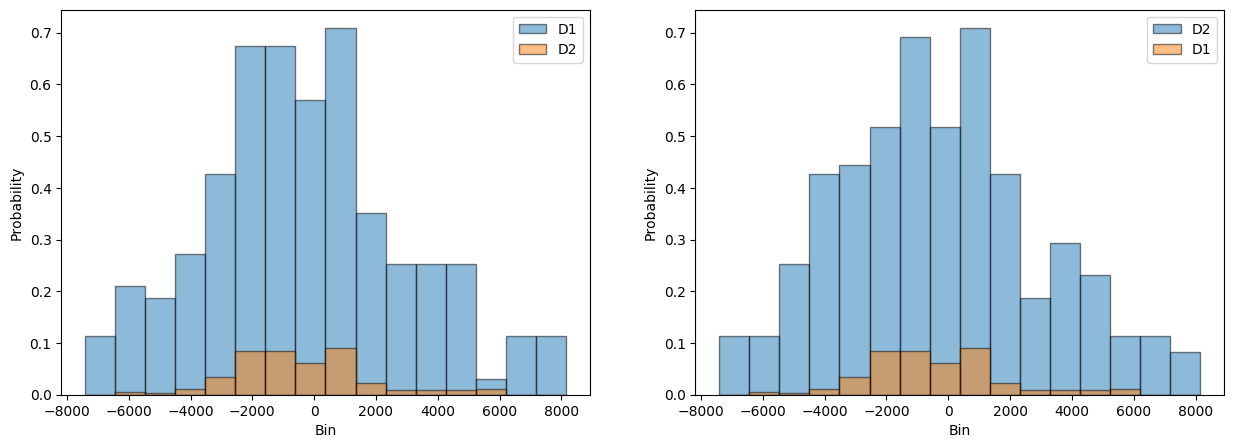

Testing:  01_1
Mean signed deviation ratio to actual:  0.8655687993061173
p-Value of 1 sample t-test:  0.15585288312703388
DP Predicate Test Result:  True


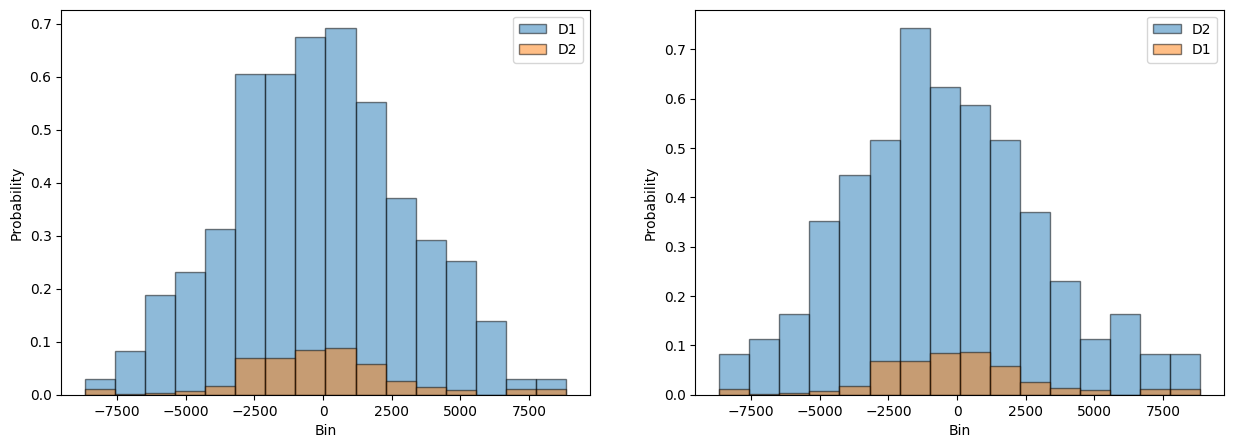

Test case:  [250.0, 555.5555555555554, -920.0]
Testing:  012_0
Mean signed deviation ratio to actual:  -0.6981073537707907
p-Value of 1 sample t-test:  0.06295239655603385
DP Predicate Test Result:  True


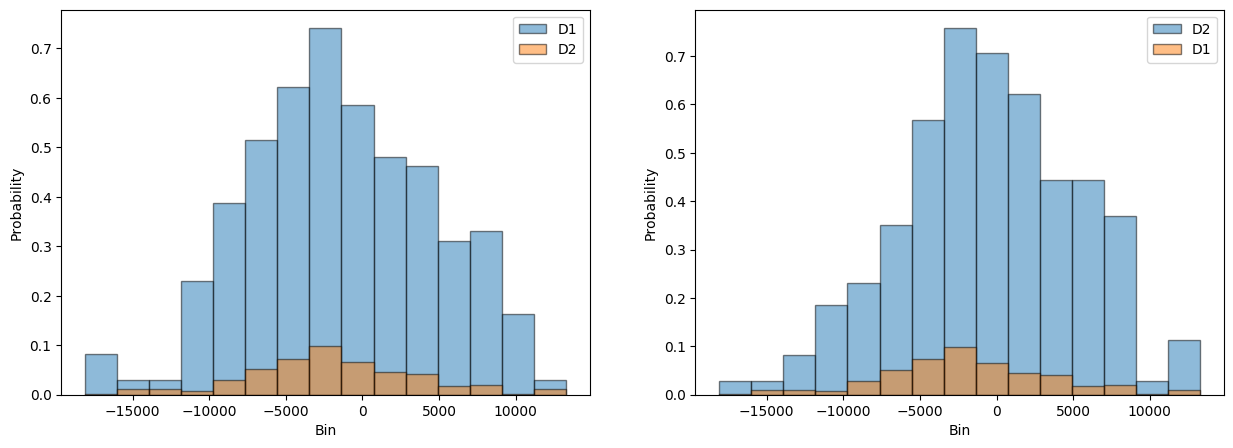

Testing:  12_1
Mean signed deviation ratio to actual:  -0.13983685081018357
p-Value of 1 sample t-test:  0.7277417090892524
DP Predicate Test Result:  True


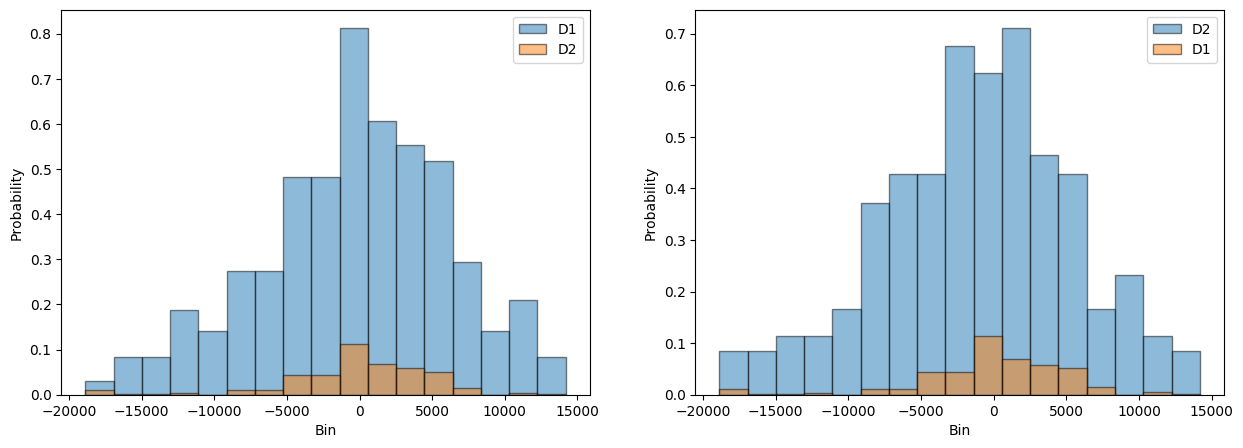

Testing:  2_2
Mean signed deviation ratio to actual:  -0.9288019917351056
p-Value of 1 sample t-test:  0.08557347391887012
DP Predicate Test Result:  True


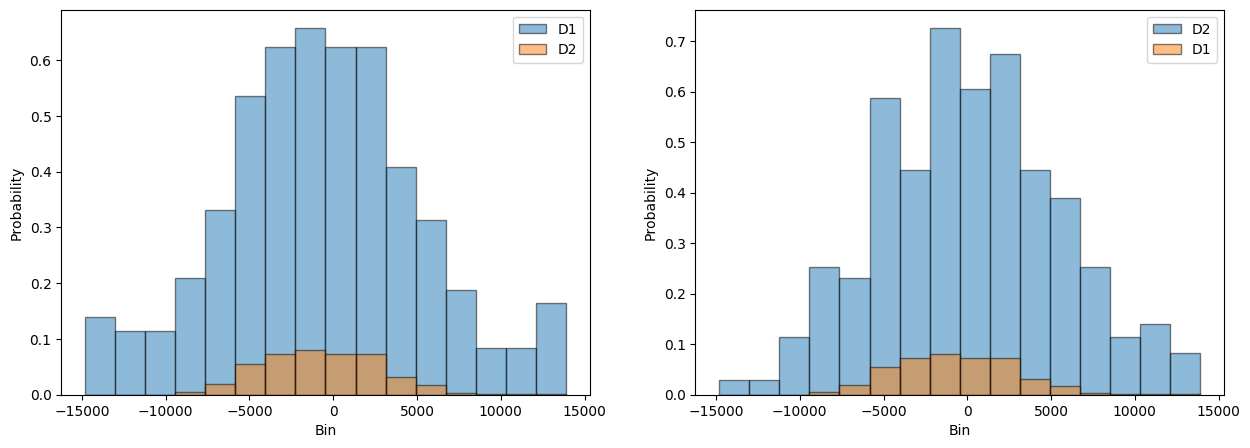

Testing:  12_2
Mean signed deviation ratio to actual:  -0.4487738694176462
p-Value of 1 sample t-test:  0.2705005495105148
DP Predicate Test Result:  True


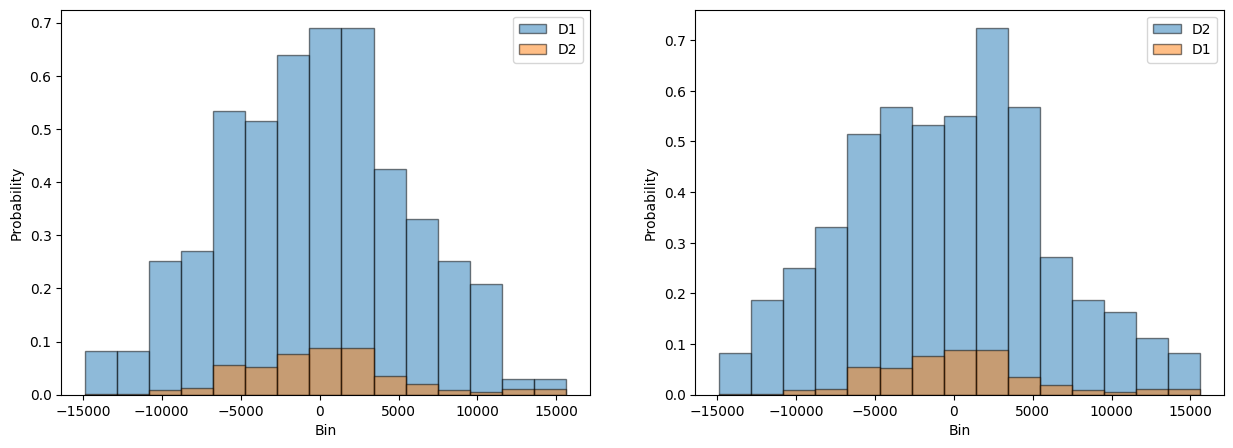

Testing:  1_1
Mean signed deviation ratio to actual:  -1.4294063594305348
p-Value of 1 sample t-test:  0.017235311844453653
DP Predicate Test Result:  True


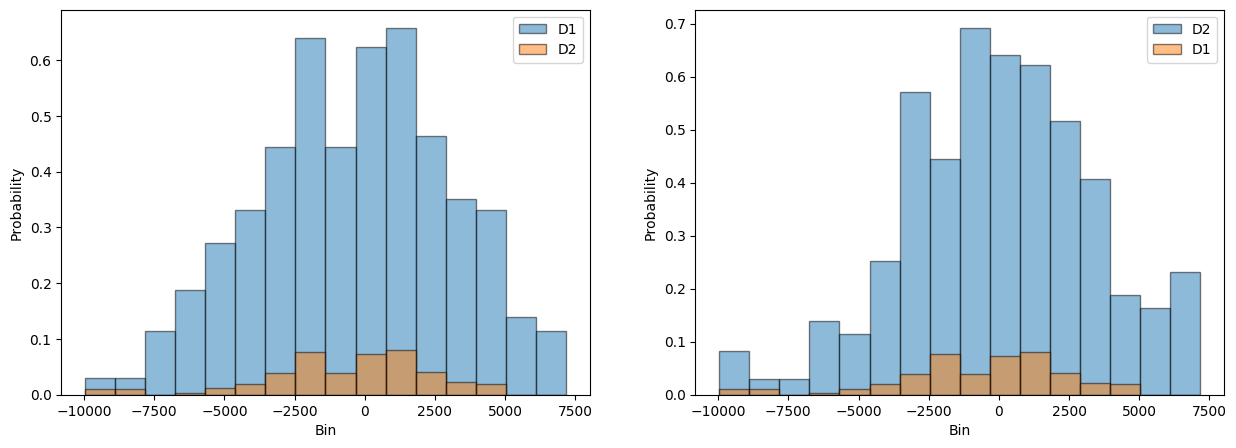

Testing:  012_1
Mean signed deviation ratio to actual:  -0.3481311419523545
p-Value of 1 sample t-test:  0.35522824436231315
DP Predicate Test Result:  True


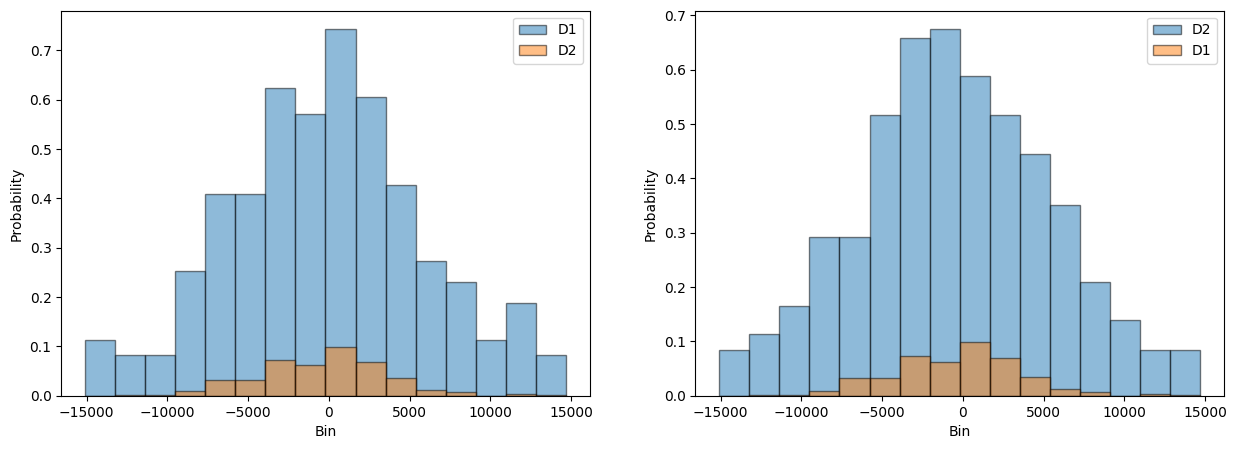

Testing:  02_0
Mean signed deviation ratio to actual:  0.18064629011391928
p-Value of 1 sample t-test:  0.7723429782730087
DP Predicate Test Result:  True


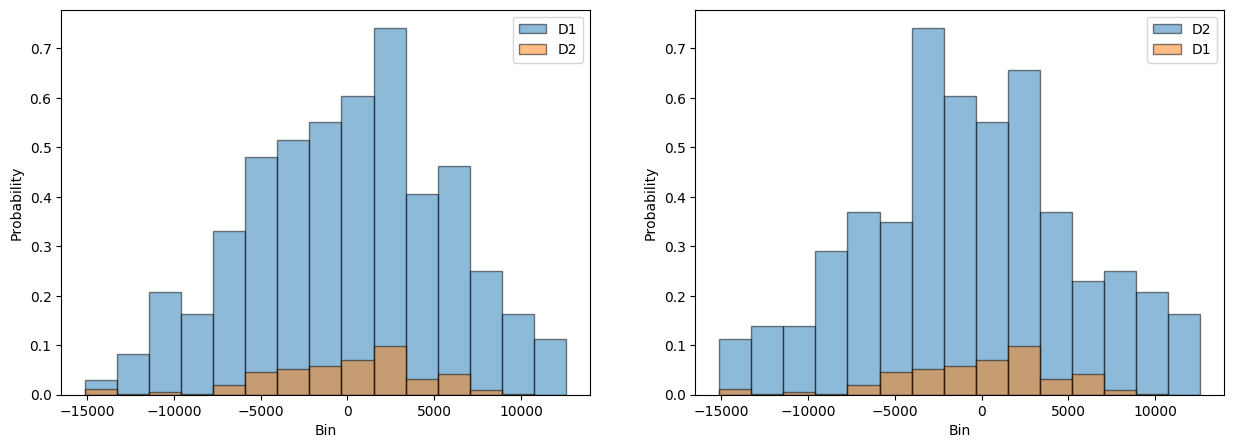

Testing:  02_2
Mean signed deviation ratio to actual:  0.6636152471408656
p-Value of 1 sample t-test:  0.23854051167467213
DP Predicate Test Result:  True


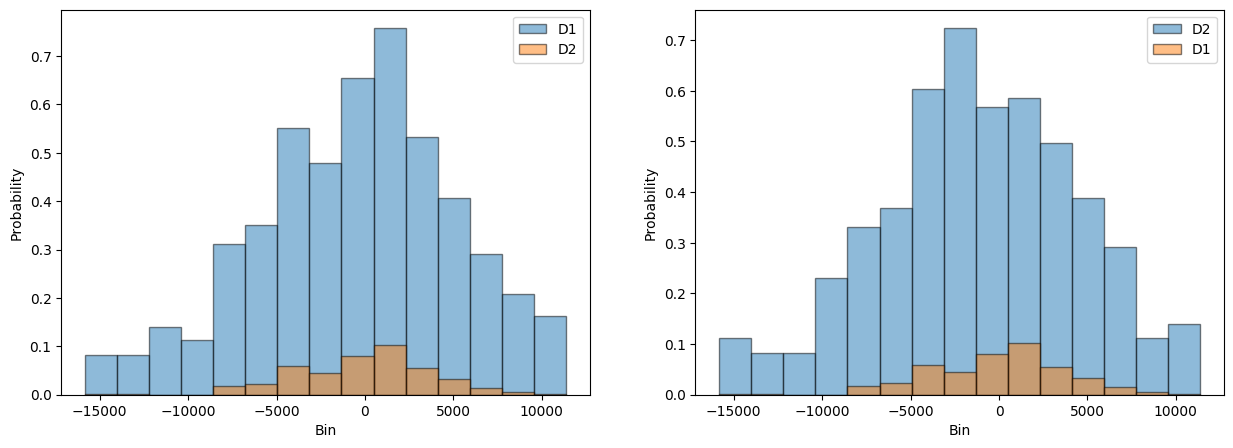

Testing:  0_0
Mean signed deviation ratio to actual:  nan
p-Value of 1 sample t-test:  nan
DP Predicate Test Result:  True


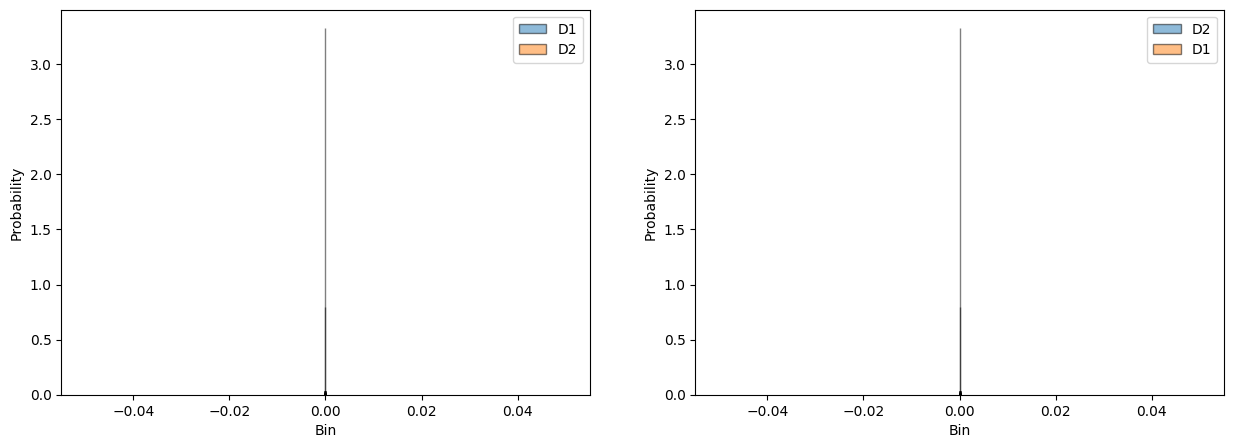

Testing:  012_2
Mean signed deviation ratio to actual:  -0.23943758062430373
p-Value of 1 sample t-test:  0.5491308139676423
DP Predicate Test Result:  True


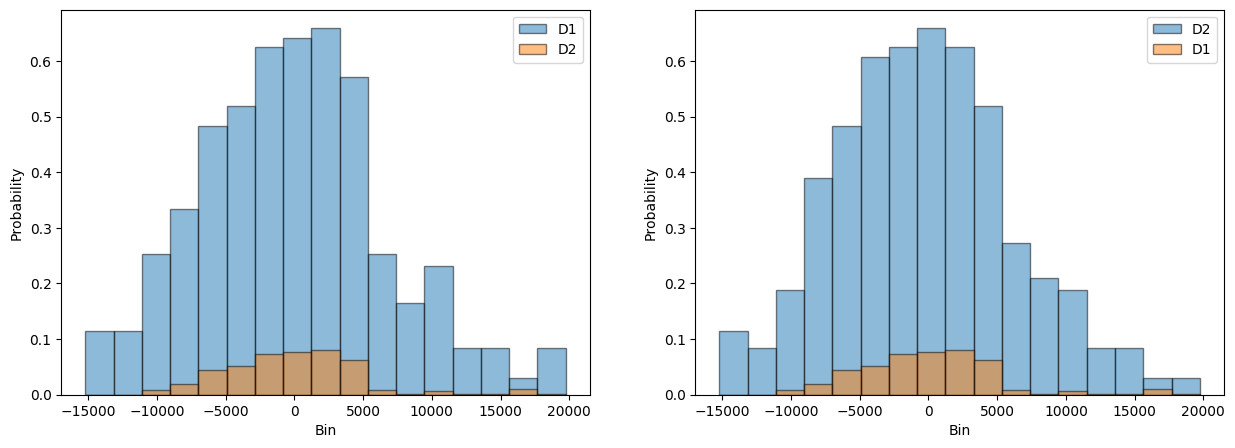

Testing:  01_0
Mean signed deviation ratio to actual:  -0.09743393479054863
p-Value of 1 sample t-test:  0.8677196587518659
DP Predicate Test Result:  True


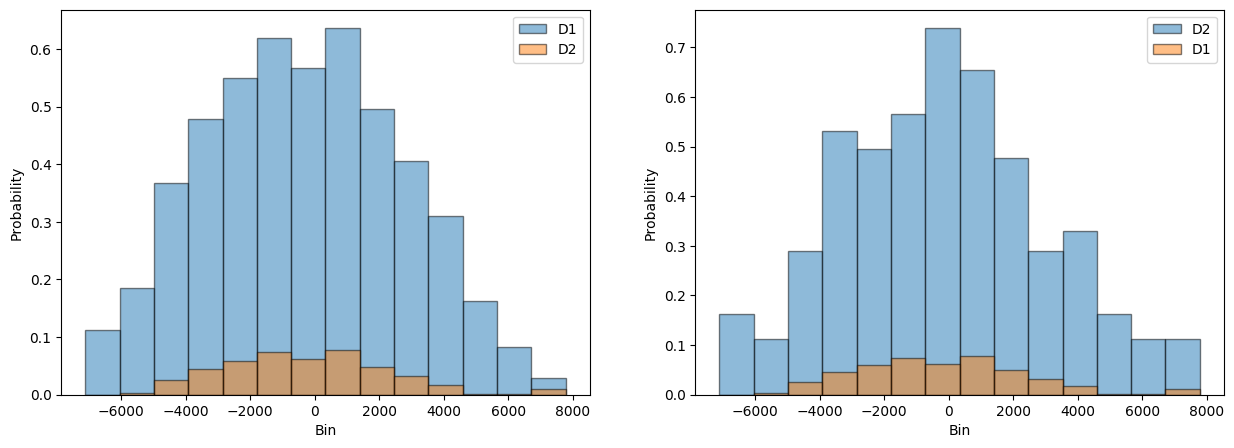

Testing:  01_1
Mean signed deviation ratio to actual:  0.18216727231699262
p-Value of 1 sample t-test:  0.7464785107808165
DP Predicate Test Result:  True


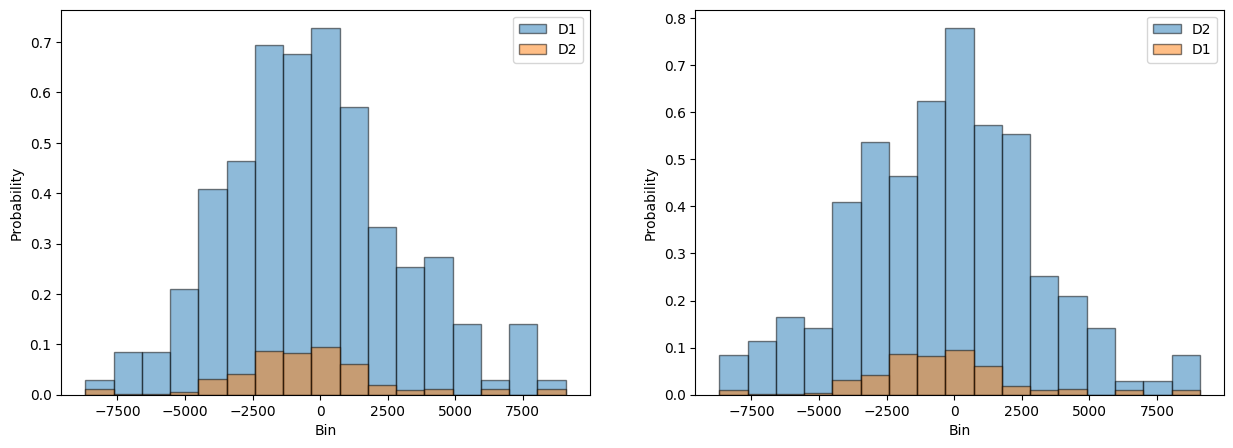

Halton sequence based Powerset Test Result
[0.0,-333.33333333333337,-600.0] - 012_0 - [True, None, None, None, True, 0.6584815068488417]
[0.0,-333.33333333333337,-600.0] - 12_1 - [True, None, None, None, True, -0.07585048566579554]
[0.0,-333.33333333333337,-600.0] - 2_2 - [True, None, None, None, True, -0.1165127211475877]
[0.0,-333.33333333333337,-600.0] - 12_2 - [True, None, None, None, True, 0.0798854113832683]
[0.0,-333.33333333333337,-600.0] - 1_1 - [True, None, None, None, False, -1.7824368672351085]
[0.0,-333.33333333333337,-600.0] - 012_1 - [True, None, None, None, True, 0.02532448207524416]
[0.0,-333.33333333333337,-600.0] - 02_0 - [True, None, None, None, True, 0.7813199821994484]
[0.0,-333.33333333333337,-600.0] - 02_2 - [True, None, None, None, True, -0.2862865632137339]
[0.0,-333.33333333333337,-600.0] - 0_0 - [True, None, None, None, False, nan]
[0.0,-333.33333333333337,-600.0] - 012_2 - [True, None, None, None, True, -0.041403931888358954]
[0.0,-333.33333333333337,-600.0

In [24]:
start_time = time.time()
query_str = "SELECT SUM(Usage) AS TotalUsage FROM "
dp_res, acc_res, utility_res, bias_res = dv.dp_powerset_test(query_str, repeat_count=200, plot=True)
print("DP Predicate Test: ", dp_res)
#print("Accuracy Test: ", acc_res)
#print("Utility Test: ", utility_res)
print("Bias Test: ", bias_res)
print("--- %s seconds ---" % (time.time() - start_time))